In [505]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import torch

In [506]:
data = pd.read_csv("/content/drive/MyDrive/롤 데이터 분석/data/data.csv")
data

,role,teamPosition,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,changed_rank
0,DUO,MIDDLE,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,1259.059313
1,SUPPORT,UTILITY,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,1260.650803
2,SUPPORT,UTILITY,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,1260.123472
3,SUPPORT,UTILITY,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,1261.719654
4,SUPPORT,UTILITY,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,1259.984844
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280307,DUO,BOTTOM,475.414011,0.818182,1.088921,15.566667,0.449679,48.886510,692.955032,429.122056,7.708779,9.000000,1728.534431
280308,CARRY,BOTTOM,404.748984,0.428571,1.130824,30.550000,0.360065,208.936170,499.148936,664.877250,7.888707,3.000000,1731.683667
280309,CARRY,BOTTOM,390.469784,0.625000,1.110857,26.683333,0.637102,268.069956,476.514678,841.086821,7.307933,1.875000,1726.496888
280310,SOLO,BOTTOM,315.656164,0.294118,1.083939,28.816667,0.277617,218.727588,201.619433,664.303065,7.252747,0.833333,1733.348616


In [507]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280312 entries, 0 to 280311
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   role                   280312 non-null  object 
 1   teamPosition           280312 non-null  object 
 2   goldPerMinute          280312 non-null  float64
 3   killParticipation      280312 non-null  float64
 4   visionScorePerMinute   280312 non-null  float64
 5   game_duration          280312 non-null  float64
 6   pings.per.min          280312 non-null  float64
 7   objectDealt.per.min    280312 non-null  float64
 8   championDealt.per.min  280312 non-null  float64
 9   tankorheals.per.min    280312 non-null  float64
 10  cs.per.min             280312 non-null  float64
 11  KDA                    280312 non-null  float64
 12  changed_rank           280312 non-null  float64
dtypes: float64(11), object(2)
memory usage: 27.8+ MB


## 변수설명

* goldPerMinute : 1분동안 먹은 재화의 양

* killParticipation: 플레이어가 팀의 전체 처치(kill) 수에 기여한 정도

* visionScorePerMinute: 1분 동안의 시야 점수(vision score) 시야 점수는 플레이어가 맵에 설치한 와드, 적의 와드를 제거한 수 등을 종합적으로 반영한 점수. 맵 컨트롤과 시야 확보의 효율성 지표

* game_duration: 게임의 총 지속 시간(분 단위)

* pings.per.min: 1분 동안 플레이어가 보내는 핑(ping)의 수. 핑은 팀원에게 정보를 전달하는 수단으로, 전략적인 의사소통을 반영

* objectDealt.per.min: 1분 동안 플레이어가 처리한 오브젝트(예: 타워, 드래곤, 바론)의 수

* championDealt.per.min: 1분 동안 플레이어가 적 챔피언에게 입힌 피해량

* tankorheals.per.min: 플레이어가 탱크 역할(피해 흡수)이나 치유(힐)를 제공한 양

* cs.per.min: 1분 동안 플레이어가 수집한 크립 스코어(Creep Score) 수. 크립 스코어는 게임 내 미니언 또는 몬스터 처치의 수를 의미하며, 경제적 성과와 게임의 성장도와 직결.

* KDA: (Kill+Death)/Assist. 플레이어의 전투 성과와 생존성을 측정하는 지표.

이는 플레이어의 전투 성과와 생존성을 측정하는 지표입니다.

* tier:  BRONZE, SILVER, GOLD, PLATINUM, EMERALD, DIAMOND로 높은 순.



In [508]:
data.describe()

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,changed_rank
count,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000,280312.000000
mean,389.090754,0.448711,0.979091,27.375071,0.951787,557.669790,602.429546,814.324801,5.401642,3.397233,2189.863126
std,86.403196,0.155995,0.624007,6.720198,0.713580,510.666815,278.984237,281.098201,2.417467,3.712338,678.002309
min,151.633237,0.017857,0.000000,15.000000,0.020284,0.000000,4.262648,10.042699,0.000000,0.066667,980.922855
25%,325.708468,0.333333,0.562765,22.916667,0.406859,156.210220,392.919786,612.459499,4.470552,1.250000,1582.624894
50%,386.957521,0.450000,0.784068,27.450000,0.773694,411.757188,572.135976,781.202421,5.992707,2.200000,2193.728662
75%,448.324201,0.555556,1.146872,31.783333,1.321613,830.091712,774.605145,987.786443,7.094205,4.000000,2767.634837
max,661.587402,0.947368,5.729648,66.216667,3.540731,6396.807175,2334.818288,3093.151079,13.756309,42.000000,3415.988703


In [509]:
data.isna().sum()

,0
role,0
teamPosition,0
goldPerMinute,0
killParticipation,0
visionScorePerMinute,0
game_duration,0
pings.per.min,0
objectDealt.per.min,0
championDealt.per.min,0
tankorheals.per.min,0


In [510]:
# R에서 회귀분석을 진행했으나 데이터의 한계로 종속 변수를 범주형으로 전환
# 티어를 회귀 -> 분류. 총 6개로 압축
# 980.9229 ~ 1386.7672 는 BRONZE
# 1386.7672 ~ 1792.6115는 SILVER
# 1792.6115 ~ 2198.4558는 GOLD
# 2198.4558 ~ 2604.3001는 PLATINUM
# 2604.3001 ~ 3010.1444 는 EMERALD
# 3010.1444 ~ 3415.9887 는 DIAMOND

In [511]:
data['tier'] = data['changed_rank'].apply(lambda x: 'BRONZE' if 980.9229 <= x <= 1386.7672
                                          else 'SILVER' if 1386.7672 < x <= 1792.6115
                                          else 'GOLD' if 1792.6115 < x <= 2198.4558
                                          else 'PLATINUM' if 2198.4558 < x <= 2604.3001
                                          else 'EMERALD' if 2604.3001 < x <= 3010.1444
                                          else 'DIAMOND')
data = data.drop(['changed_rank'],axis=1)
data

,role,teamPosition,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,tier
0,DUO,MIDDLE,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,BRONZE
1,SUPPORT,UTILITY,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,BRONZE
2,SUPPORT,UTILITY,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,BRONZE
3,SUPPORT,UTILITY,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,BRONZE
4,SUPPORT,UTILITY,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,BRONZE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280307,DUO,BOTTOM,475.414011,0.818182,1.088921,15.566667,0.449679,48.886510,692.955032,429.122056,7.708779,9.000000,SILVER
280308,CARRY,BOTTOM,404.748984,0.428571,1.130824,30.550000,0.360065,208.936170,499.148936,664.877250,7.888707,3.000000,SILVER
280309,CARRY,BOTTOM,390.469784,0.625000,1.110857,26.683333,0.637102,268.069956,476.514678,841.086821,7.307933,1.875000,SILVER
280310,SOLO,BOTTOM,315.656164,0.294118,1.083939,28.816667,0.277617,218.727588,201.619433,664.303065,7.252747,0.833333,SILVER


In [512]:
data.value_counts('tier')

,count
tier,
EMERALD,51786
GOLD,48431
SILVER,47519
PLATINUM,45619
BRONZE,44768
DIAMOND,42189


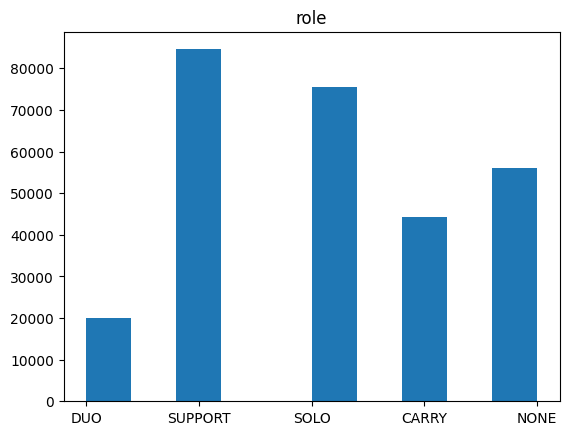

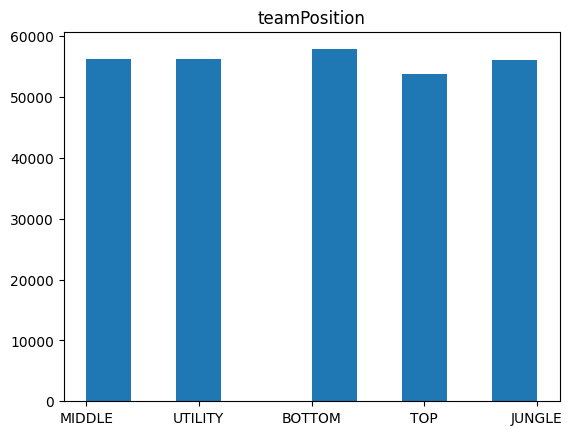

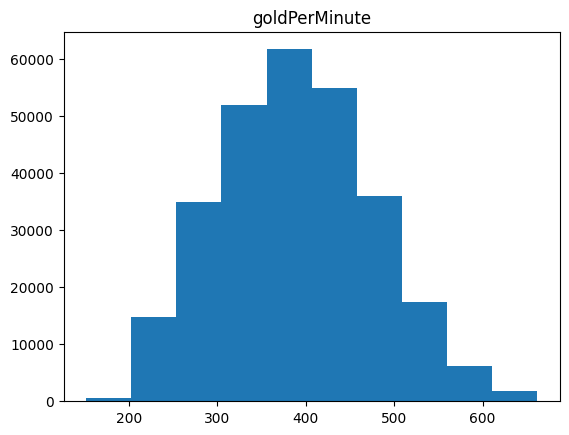

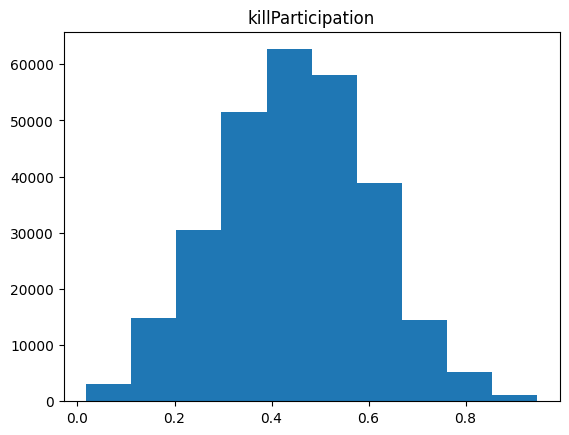

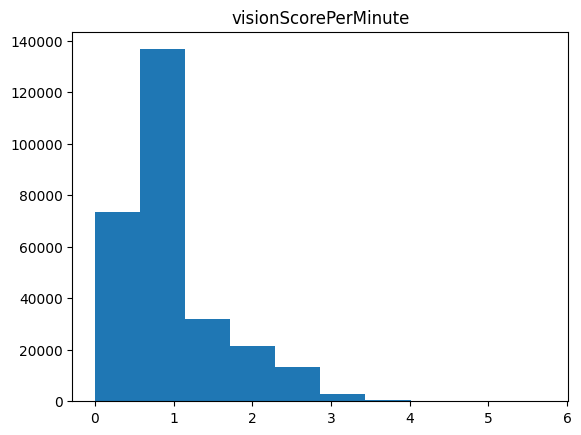

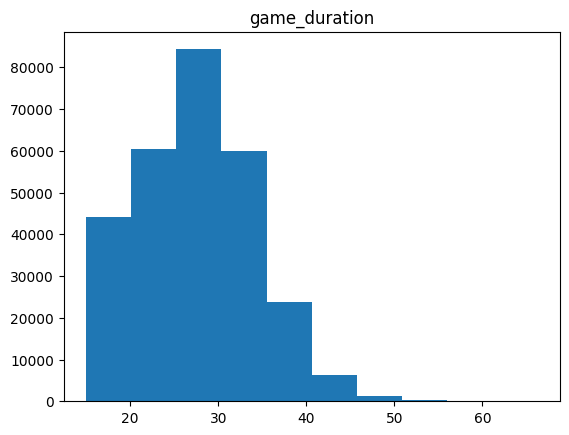

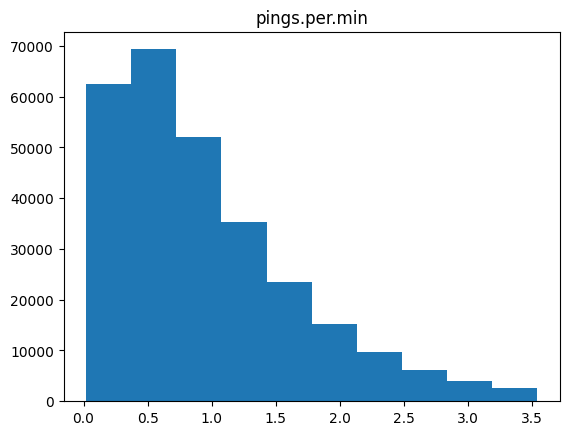

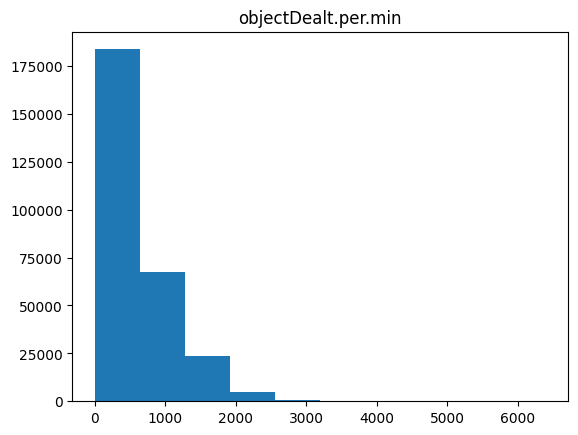

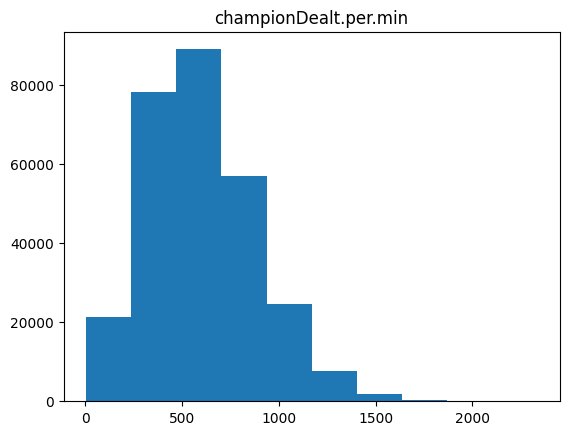

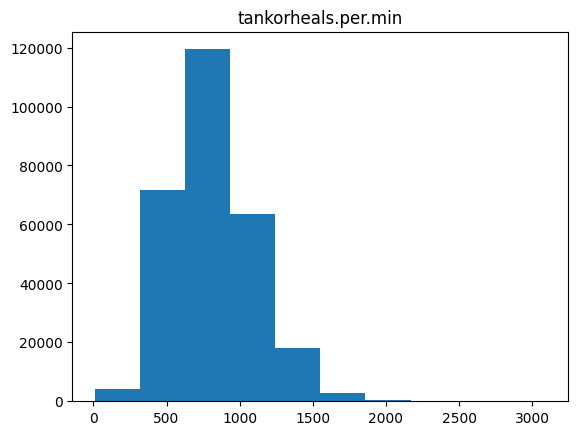

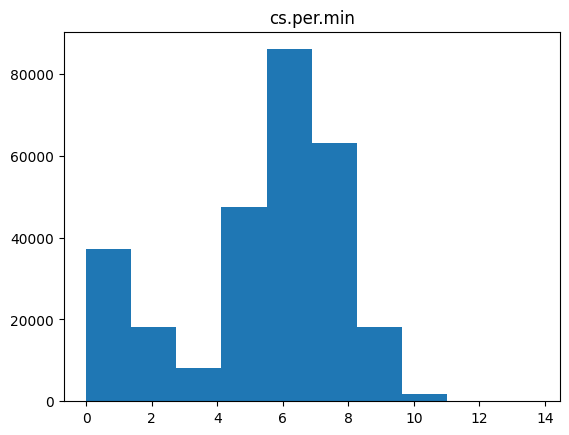

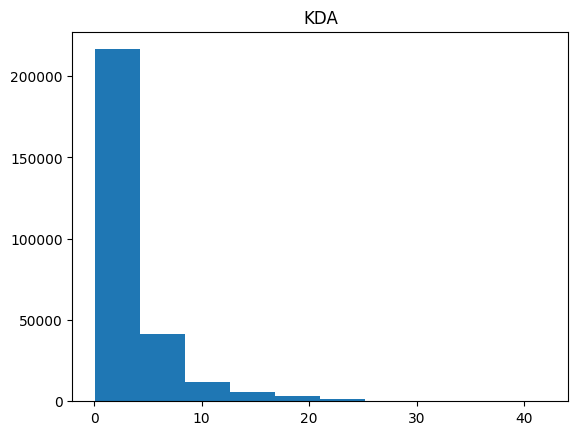

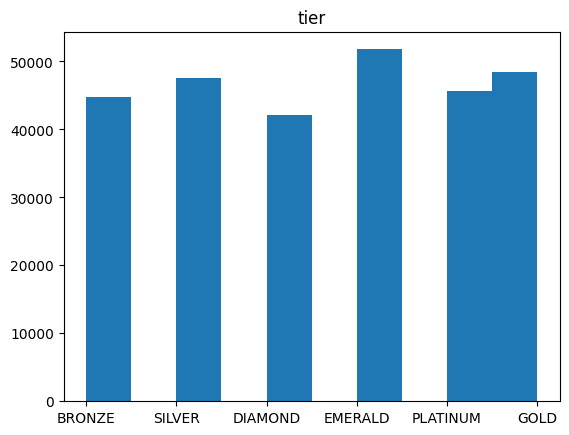

In [513]:
for col in data.columns:
    plt.hist(data[col])
    plt.title(col)
    plt.show()

In [514]:
float_data = data.select_dtypes(include='object')
for col in float_data.columns:
    print(float_data[col].value_counts())

role
SUPPORT    84581
SOLO       75448
NONE       56058
CARRY      44279
DUO        19946
Name: count, dtype: int64
teamPosition
BOTTOM     57867
MIDDLE     56332
UTILITY    56227
JUNGLE     56060
TOP        53826
Name: count, dtype: int64
tier
EMERALD     51786
GOLD        48431
SILVER      47519
PLATINUM    45619
BRONZE      44768
DIAMOND     42189
Name: count, dtype: int64


In [515]:
list = ['role','teamPosition']
list

['role', 'teamPosition']

In [516]:
data = pd.get_dummies(data,columns=list)
data

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,...,False,True,False,False,False,False,False,True,False,False
1,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,...,False,False,False,False,True,False,False,False,False,True
2,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,...,False,False,False,False,True,False,False,False,False,True
3,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,...,False,False,False,False,True,False,False,False,False,True
4,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280307,475.414011,0.818182,1.088921,15.566667,0.449679,48.886510,692.955032,429.122056,7.708779,9.000000,...,False,True,False,False,False,True,False,False,False,False
280308,404.748984,0.428571,1.130824,30.550000,0.360065,208.936170,499.148936,664.877250,7.888707,3.000000,...,True,False,False,False,False,True,False,False,False,False
280309,390.469784,0.625000,1.110857,26.683333,0.637102,268.069956,476.514678,841.086821,7.307933,1.875000,...,True,False,False,False,False,True,False,False,False,False
280310,315.656164,0.294118,1.083939,28.816667,0.277617,218.727588,201.619433,664.303065,7.252747,0.833333,...,False,False,False,True,False,True,False,False,False,False


In [517]:
tier_order = ['BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND']

In [518]:
data.columns

Index(['goldPerMinute', 'killParticipation', 'visionScorePerMinute',
       'game_duration', 'pings.per.min', 'objectDealt.per.min',
       'championDealt.per.min', 'tankorheals.per.min', 'cs.per.min', 'KDA',
       'tier', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO',
       'role_SUPPORT', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
       'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY'],
      dtype='object')

In [519]:
len(data.columns)

21

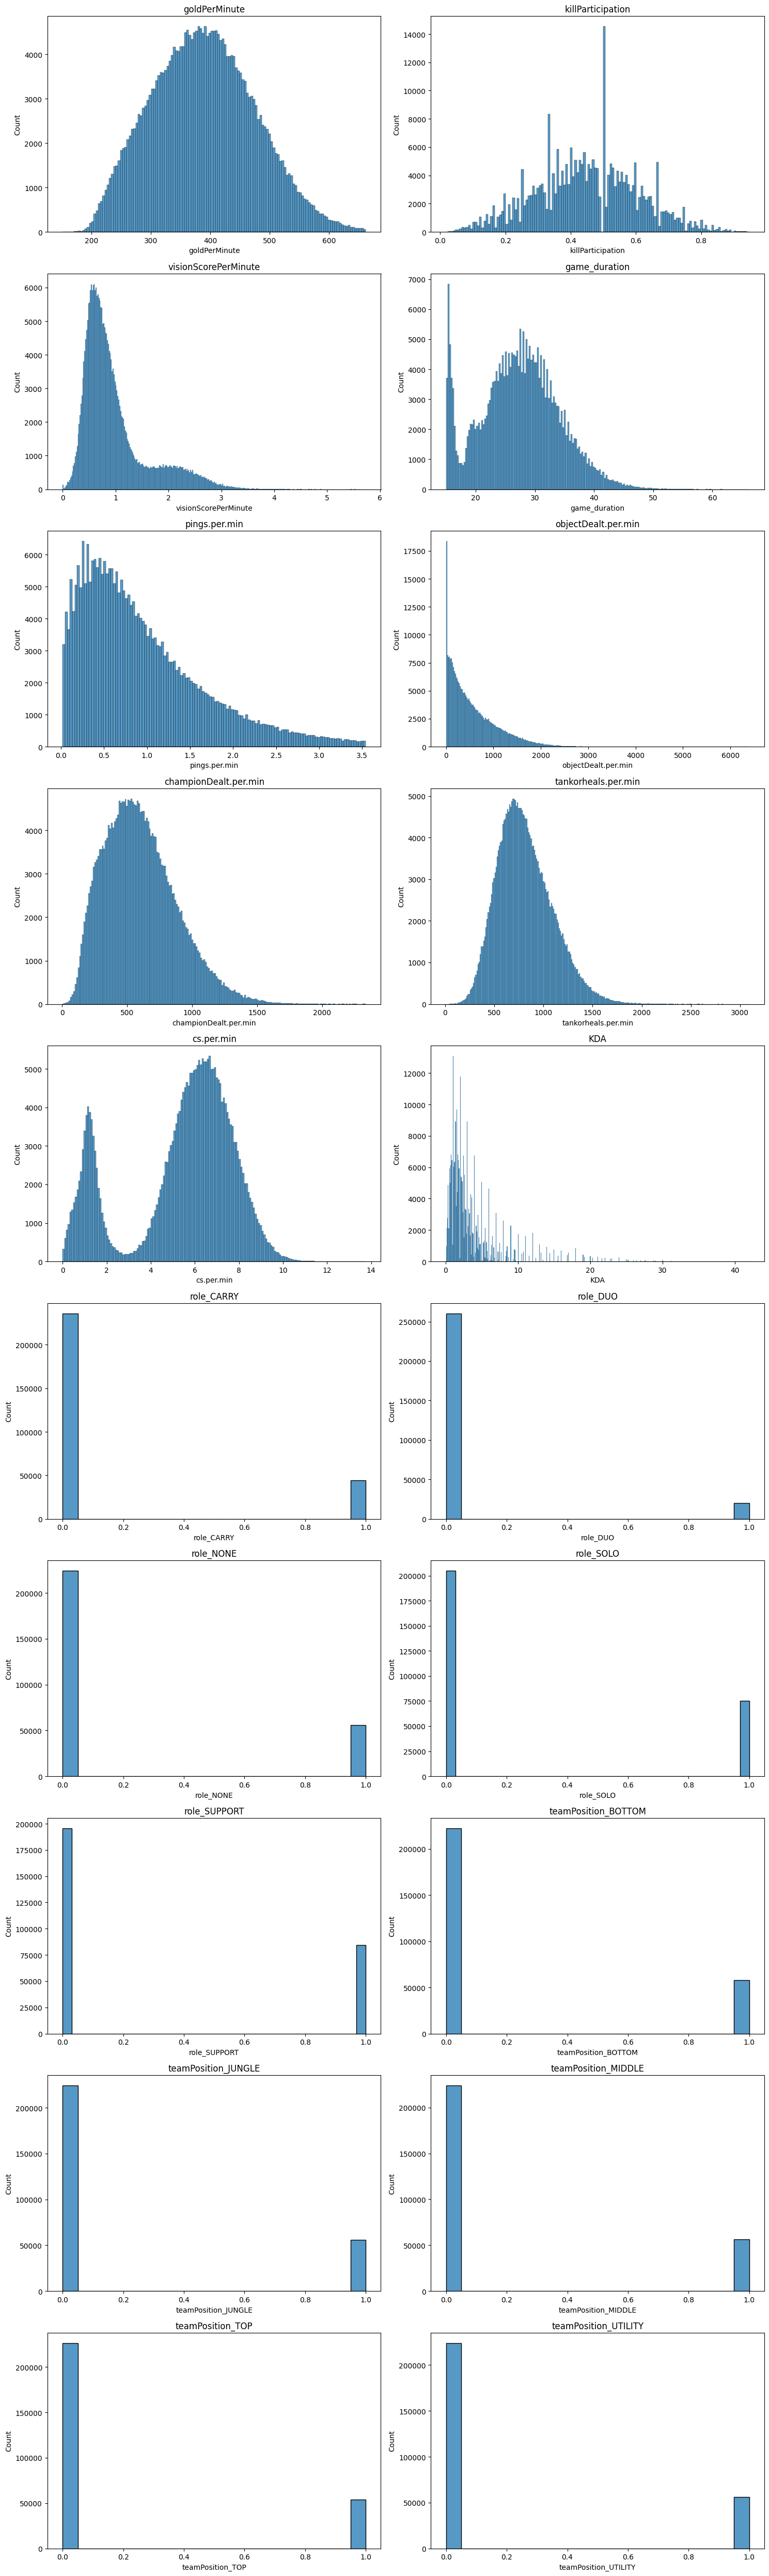

In [520]:
variables = [col for col in data.columns if col != 'tier']
fig, axes = plt.subplots(10, 2, figsize=(15, 10 * 5))
axes = axes.flatten()


for idx, var in enumerate(variables):
    sns.histplot(data[var], ax=axes[idx])
    axes[idx].set_title(f'{var}')


for idx in range(len(variables), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



In [521]:
data.columns

Index(['goldPerMinute', 'killParticipation', 'visionScorePerMinute',
       'game_duration', 'pings.per.min', 'objectDealt.per.min',
       'championDealt.per.min', 'tankorheals.per.min', 'cs.per.min', 'KDA',
       'tier', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO',
       'role_SUPPORT', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
       'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY'],
      dtype='object')

In [522]:
# 문제가 있어보이는 독립 변수 : killParticipation, visionScorePerMinute, game_duration,pings.per.min,objectDealt.per.min,cs.per.min,KDA

# 데이터 불균형 문제

# 정확도는 높지만 손실 함수가 줄어들지 않는다면,
# 드문 클래스에 대한 손실이 크기 때문에 전체 손실의 감소 저하
# 오버샘플링, 언더샘플링, 또는 클래스 가중치 조정.
# 생성형 AI 모델을 사용한 데이터 증강

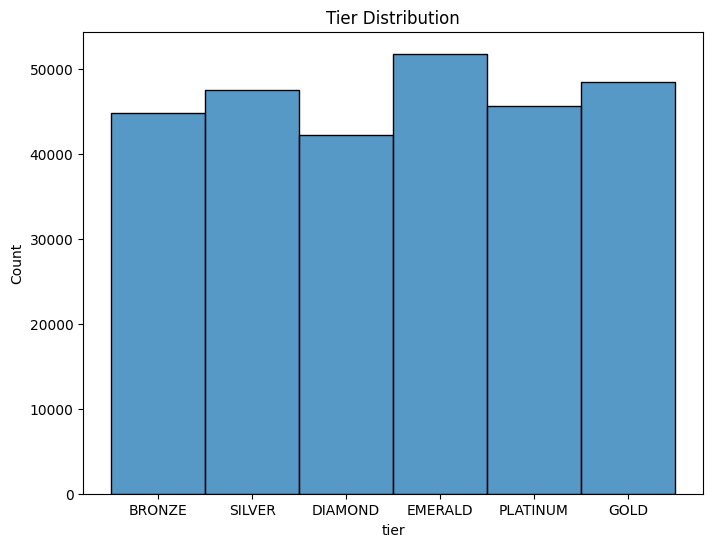

In [523]:
plt.figure(figsize=(8, 6))
sns.histplot(data['tier'], discrete=True)
plt.title('Tier Distribution')
plt.show()

In [524]:
# 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND'
bronze_data = data[data['tier'] == 'BRONZE']
silver_data = data[data['tier'] == 'SILVER']
gold_data = data[data['tier'] == 'GOLD']
platinum_data = data[data['tier'] == 'PLATINUM']
emerald_data = data[data['tier'] == 'EMERALD']
diamond_data = data[data['tier'] == 'DIAMOND']

In [525]:
combined_data = pd.concat([
    bronze_data.assign(Tier='BRONZE'),
    diamond_data.assign(Tier='DIAMOND')
])

In [526]:
numeric_cols = combined_data.select_dtypes(include='number').columns

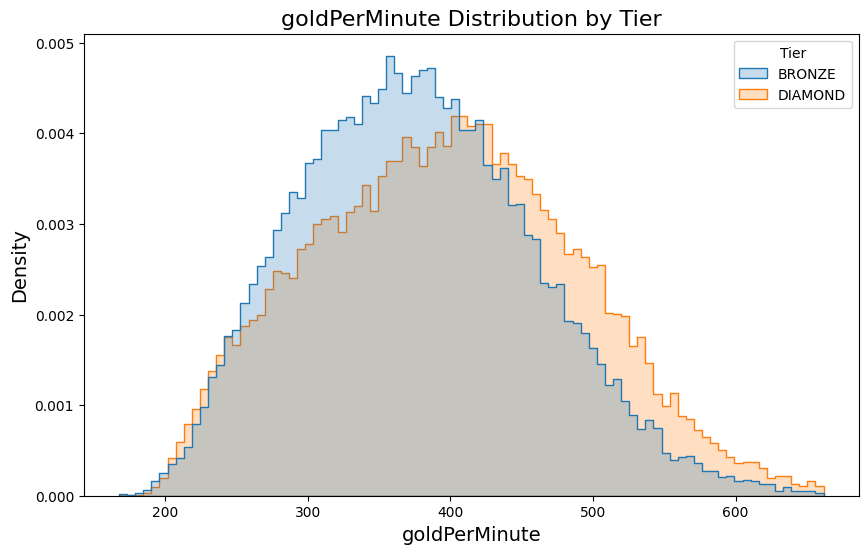

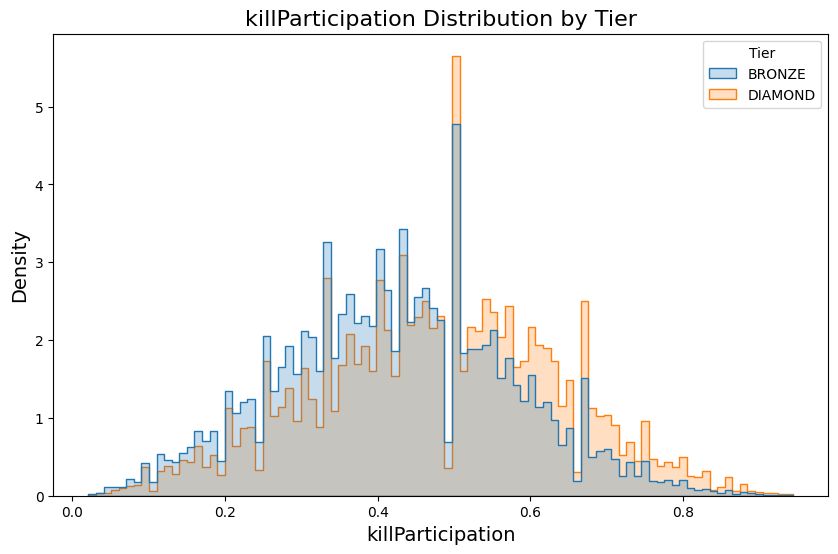

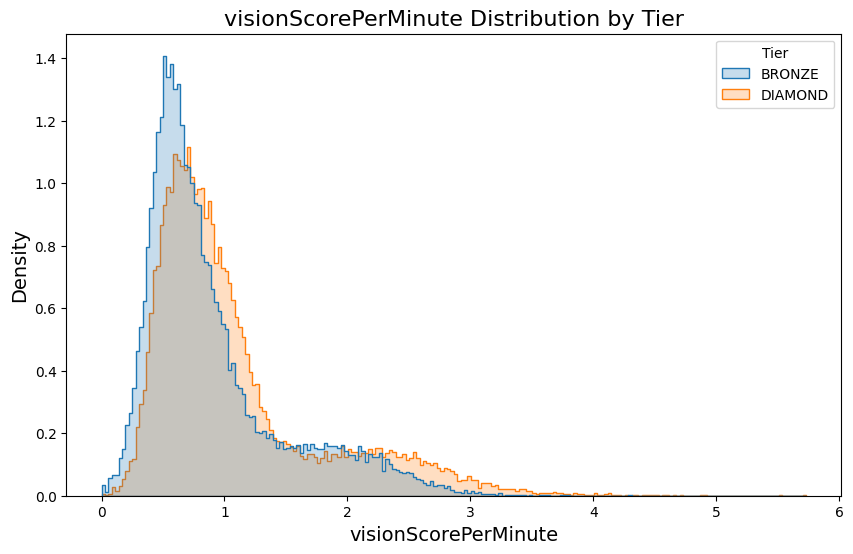

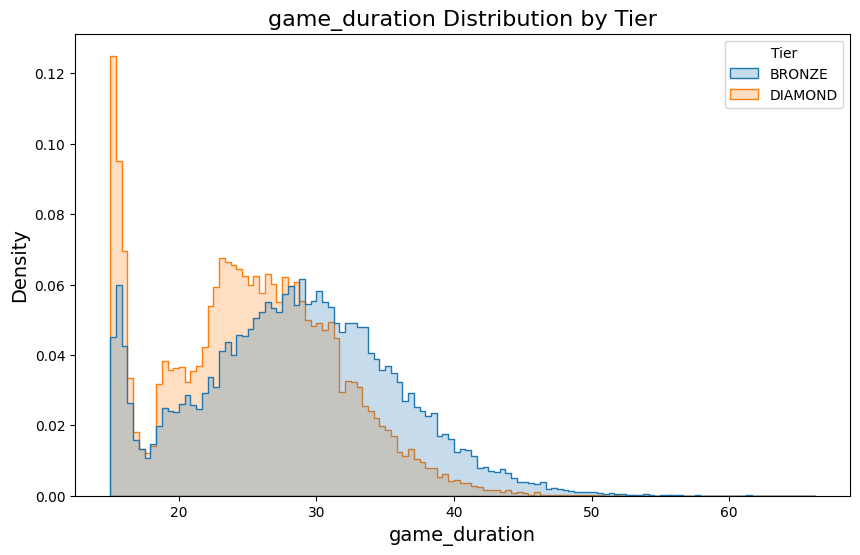

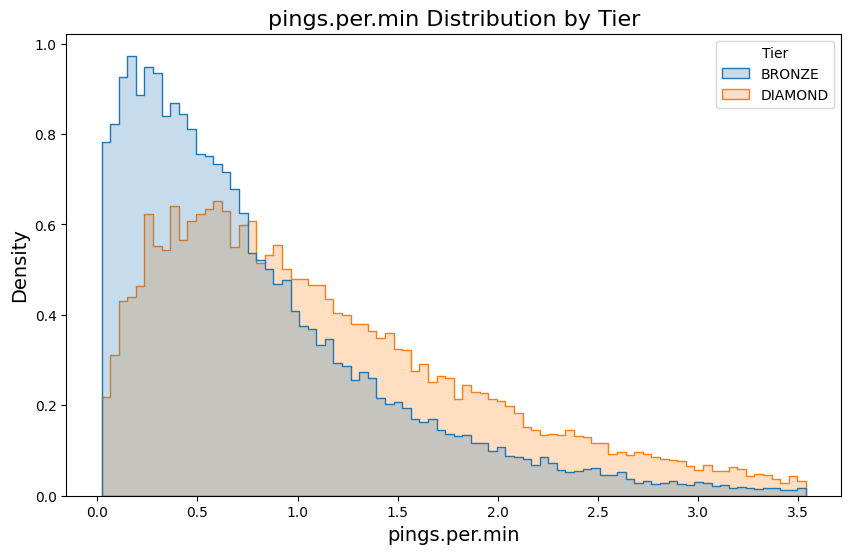

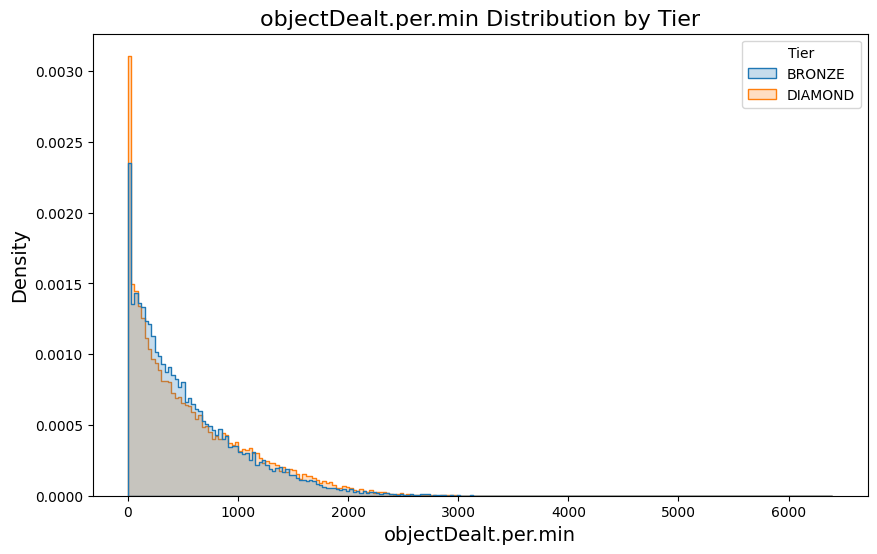

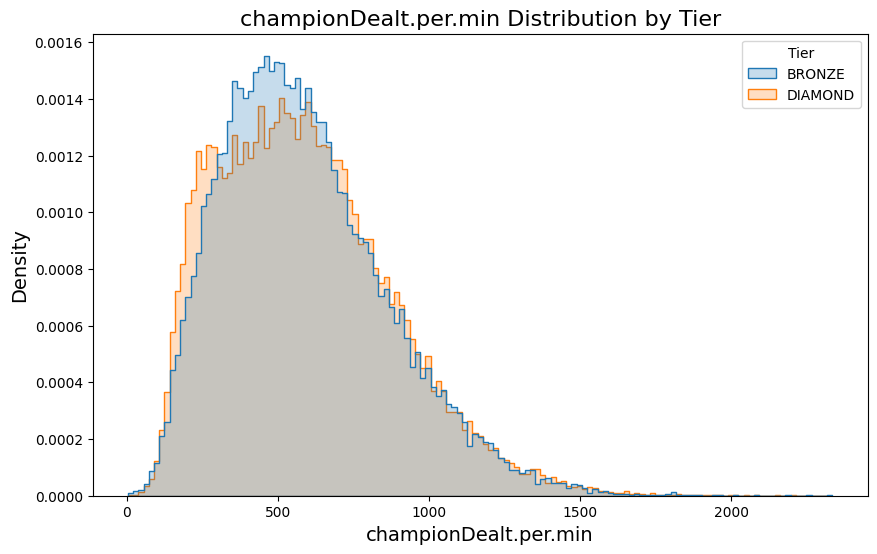

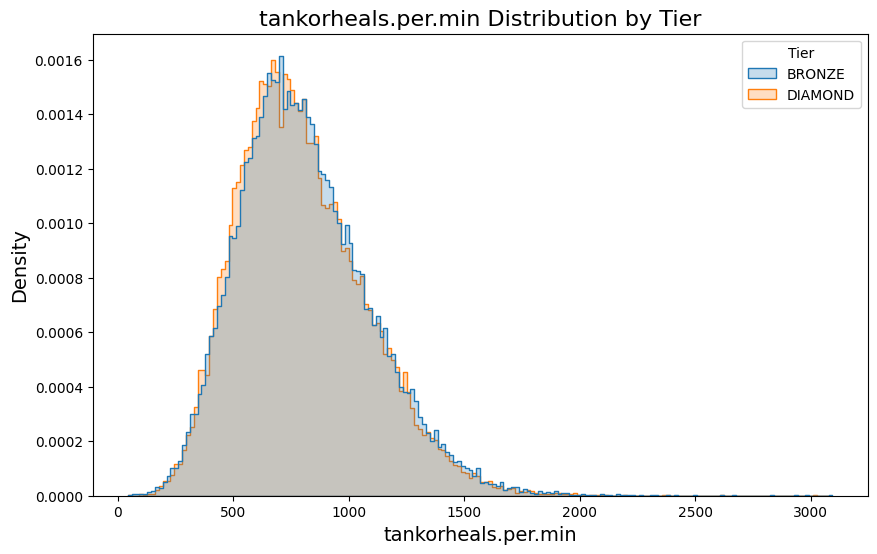

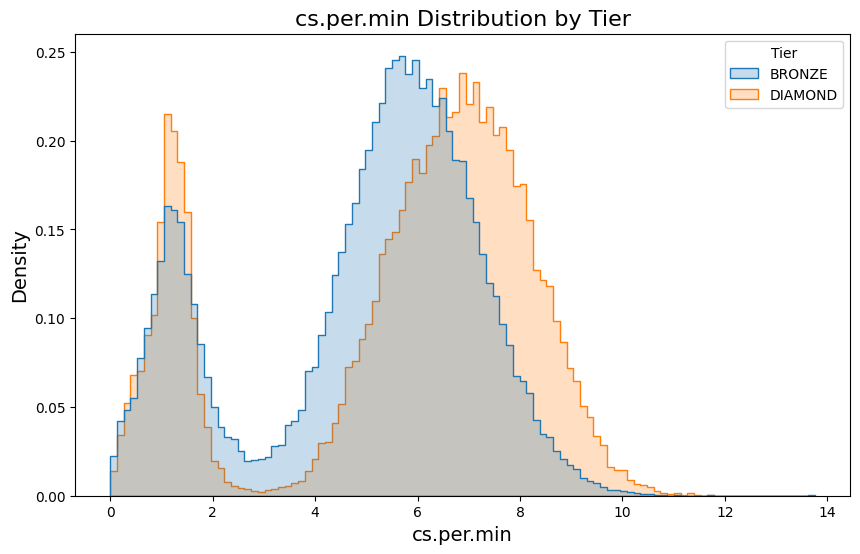

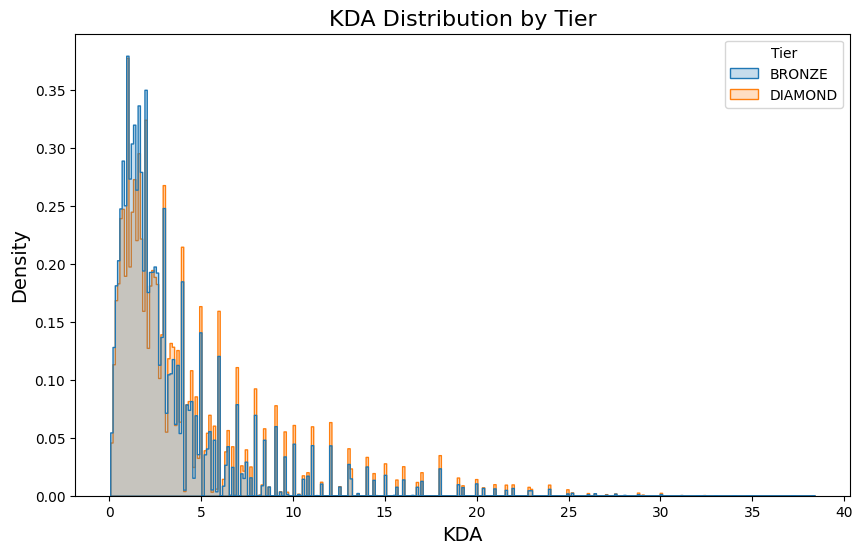

In [527]:
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_data, x=col, hue='Tier', element='step', stat='density', common_norm=False)

    plt.title(f'{col} Distribution by Tier', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.show()

In [528]:
### 일단은 해당 데이터로 진행하나 더 정확한 분석을 위해서는 새 변수나 파생변수가 필요해보임.

In [529]:
len(data)

280312

### cs.per.min 변수

In [530]:
## cs.per.min이 양봉형인 이유 : teamPosition 중 서포터 역할인 UTILITY는 게임의 관행 상 cs를 먹지 않음.
## data['cs_per_min_binned'] = pd.cut(data['cs.per.min'], bins=[0, 2, 4, 6, 8, 10], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) 아예 범주로 변환 원핫인코딩?
## => 서포터가 아닌데 cs.per.min 값이 3보다 작은 값들 개수만 삭제하기

((data['teamPosition_UTILITY'] == 0) & (data['cs.per.min'] <= 3)).sum()

603

In [531]:
# 서포터가 아니면서 cs.per.min 값이 3 이하인 데이터
condition_to_drop = (data['teamPosition_UTILITY'] == 0) & (data['cs.per.min'] <= 3)

index_to_drop = data[condition_to_drop].index

# 해당 인덱스의 삭제
data = data.drop(index_to_drop)

print(data.shape)

(279709, 21)


### game_duration 변수

In [532]:
# 너무 짧은 게임 시간
len(data[data['game_duration'] <= 17])

26241

In [533]:
np.random.seed(2023)
# game_duration이 17 이하인 데이터 필터링
filtered_data = data[data['game_duration'] <= 17]

# 랜덤한 4000개의 샘플 추출
sampled_data = filtered_data.sample(n=4000, random_state=2023)
len(sampled_data)

4000

In [534]:
# filtered_data를 드롭하고 sampled_data로 대체
data = pd.concat([data[~data.index.isin(filtered_data.index)], sampled_data])

print(f"Updated data shape: {data.shape}")

Updated data shape: (257468, 21)


<Axes: xlabel='game_duration', ylabel='Count'>

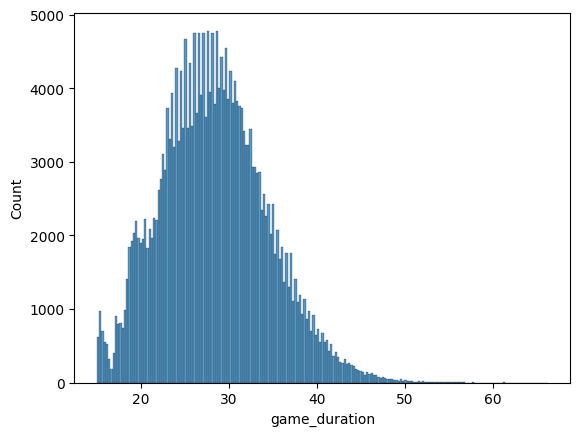

In [535]:
sns.histplot((data['game_duration']))

In [536]:
len(data['tier'])

257468

### objectDealt.per.min

<Axes: xlabel='objectDealt.per.min', ylabel='Count'>

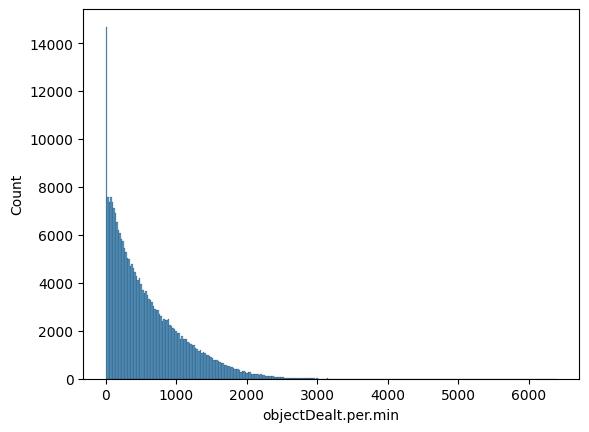

In [537]:
sns.histplot((data['objectDealt.per.min']))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='objectDealt.per.min', ylabel='Count'>

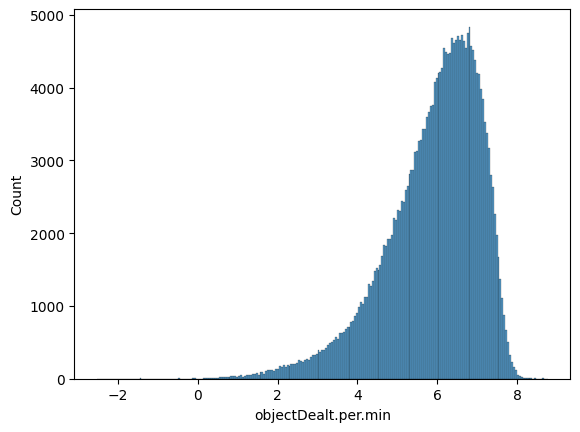

In [538]:
sns.histplot(np.log(data['objectDealt.per.min']))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='objectDealt.per.min', ylabel='tier'>

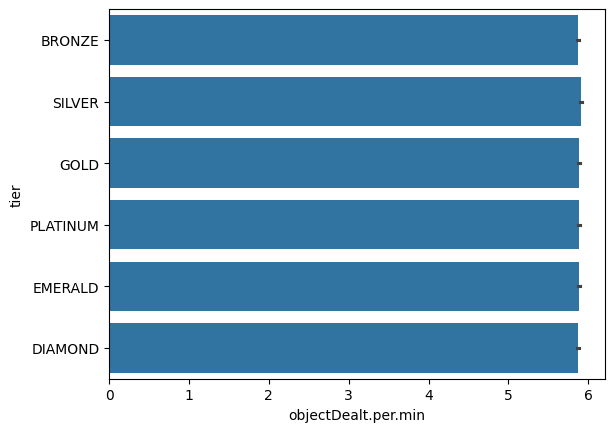

In [539]:
sns.barplot(x=np.log(data['objectDealt.per.min']), y=data['tier'], order=tier_order)

<Axes: xlabel='objectDealt.per.min', ylabel='tier'>

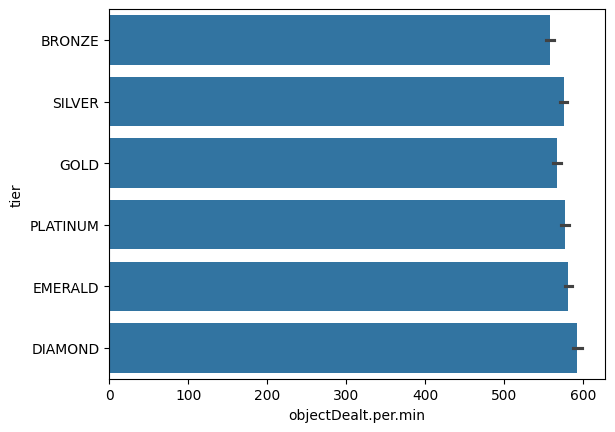

In [540]:
sns.barplot(x=(data['objectDealt.per.min']), y=data['tier'], order=tier_order)

In [541]:
bronze_data

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,...,False,True,False,False,False,False,False,True,False,False
1,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,...,False,False,False,False,True,False,False,False,False,True
2,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,...,False,False,False,False,True,False,False,False,False,True
3,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,...,False,False,False,False,True,False,False,False,False,True
4,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275561,257.491912,0.750000,1.825532,30.483333,0.557682,70.169492,328.441771,679.748496,1.541826,3.000000,...,False,False,False,False,True,False,False,False,False,True
275591,334.213090,0.526316,0.312910,29.450000,0.101868,14.702886,748.081494,802.784380,3.056027,0.833333,...,True,False,False,False,False,True,False,False,False,False
275658,361.851052,0.375000,0.687200,28.983333,1.449109,396.055204,792.834963,936.848764,6.555492,0.900000,...,False,False,False,True,False,False,False,True,False,False
275760,286.377561,0.411765,1.641504,22.700000,2.378855,174.185022,630.704846,490.000000,1.233480,1.400000,...,False,False,False,False,True,False,False,False,False,True


In [542]:
len(data)

257468

In [543]:
len(data[data['objectDealt.per.min']==0])

7465

In [544]:
# 게임 진행 중 오브젝트 자체에 공격을 한 적이 없다 == 이상치 제거대상
# 데이터에서 0 값 제거 후
bronze_data_filtered = bronze_data[bronze_data['objectDealt.per.min'] > 0]
diamond_data_filtered = diamond_data[diamond_data['objectDealt.per.min'] > 0]

# 로그변환
bronze_log_data = pd.DataFrame(np.log(bronze_data_filtered['objectDealt.per.min']))
diamond_log_data = pd.DataFrame(np.log(diamond_data_filtered['objectDealt.per.min']))


bronze_log_data['Tier'] = 'BRONZE'
diamond_log_data['Tier'] = 'DIAMOND'

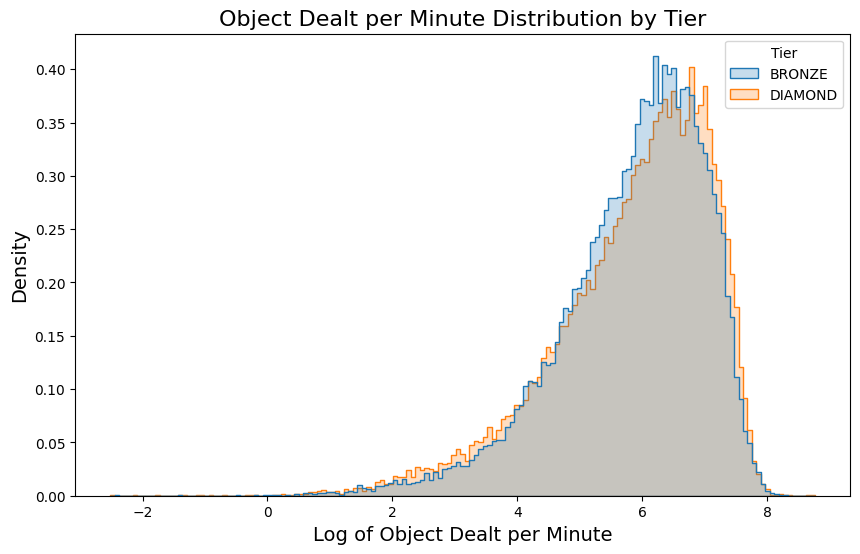

In [545]:
combined_log_data = pd.concat([
    bronze_log_data,
    diamond_log_data
])

plt.figure(figsize=(10, 6))
sns.histplot(data=combined_log_data, x='objectDealt.per.min', hue='Tier', element='step', stat='density', common_norm=False)
plt.title('Object Dealt per Minute Distribution by Tier', fontsize=16)
plt.xlabel('Log of Object Dealt per Minute', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()
# 약간의 차별점 생김

In [546]:
# 0보다 작으면 NaN
data['objectDealt.per.min'] = data['objectDealt.per.min'].where(data['objectDealt.per.min'] > 0)

# NaN 삭제
data = data.dropna(subset=['objectDealt.per.min'])

In [547]:
data

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,...,False,True,False,False,False,False,False,True,False,False
1,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,...,False,False,False,False,True,False,False,False,False,True
2,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,...,False,False,False,False,True,False,False,False,False,True
3,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,...,False,False,False,False,True,False,False,False,False,True
4,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265981,325.998530,0.666667,0.358468,15.400000,1.168831,97.207792,353.636364,419.675325,7.077922,1.000000,...,False,True,False,False,False,True,False,False,False,False
193396,300.804432,0.333333,0.172801,15.566667,1.027837,333.340471,304.689507,1014.089936,5.267666,0.125000,...,False,False,False,False,True,False,True,False,False,False
278750,337.216458,0.571429,0.750502,15.183333,0.263447,385.949506,410.976948,1153.896817,5.400659,0.800000,...,False,False,False,False,True,False,True,False,False,False
28965,343.675605,0.307692,0.983441,15.450000,3.300971,1420.129450,226.860841,599.417476,5.954693,4.800000,...,False,False,False,False,True,False,True,False,False,False


In [548]:
data['objectDealt.per.min'] = np.log(data['objectDealt.per.min'])

In [549]:
data

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,340.558038,0.281250,0.812030,22.883333,2.228696,5.238052,416.547706,332.818645,4.806992,9.000000,...,False,True,False,False,False,False,False,True,False,False
1,277.992362,0.368421,1.847087,26.150000,1.070746,5.535662,534.378585,427.227533,1.070746,1.750000,...,False,False,False,False,True,False,False,False,False,True
2,383.570747,0.533333,2.617196,21.633333,1.340524,5.587751,731.463790,334.530046,1.063174,8.000000,...,False,False,False,False,True,False,False,False,False,True
3,296.582688,0.619048,2.525915,43.000000,1.511628,4.987581,690.744186,649.348837,1.302326,2.888889,...,False,False,False,False,True,False,False,False,False,True
4,328.347939,0.380952,2.965757,26.750000,1.532710,5.496402,407.214953,553.532710,1.495327,2.666667,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265981,325.998530,0.666667,0.358468,15.400000,1.168831,4.576851,353.636364,419.675325,7.077922,1.000000,...,False,True,False,False,False,True,False,False,False,False
193396,300.804432,0.333333,0.172801,15.566667,1.027837,5.809164,304.689507,1014.089936,5.267666,0.125000,...,False,False,False,False,True,False,True,False,False,False
278750,337.216458,0.571429,0.750502,15.183333,0.263447,5.955707,410.976948,1153.896817,5.400659,0.800000,...,False,False,False,False,True,False,True,False,False,False
28965,343.675605,0.307692,0.983441,15.450000,3.300971,7.258503,226.860841,599.417476,5.954693,4.800000,...,False,False,False,False,True,False,True,False,False,False


In [550]:
len(data)

250003

### KDA

<Axes: xlabel='KDA', ylabel='Count'>

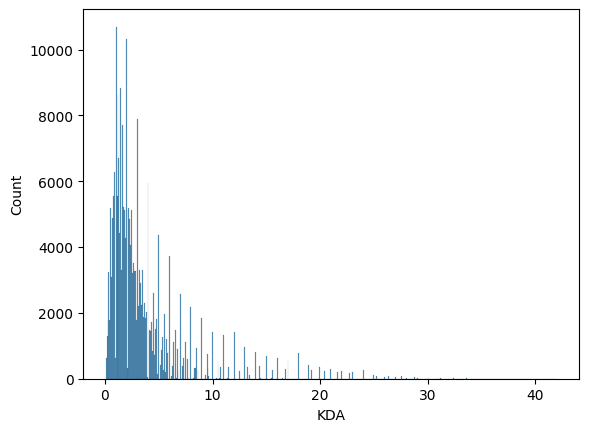

In [551]:
sns.histplot(data['KDA'])

In [552]:
len(data[data['KDA']==0])

0

<Axes: xlabel='KDA', ylabel='Count'>

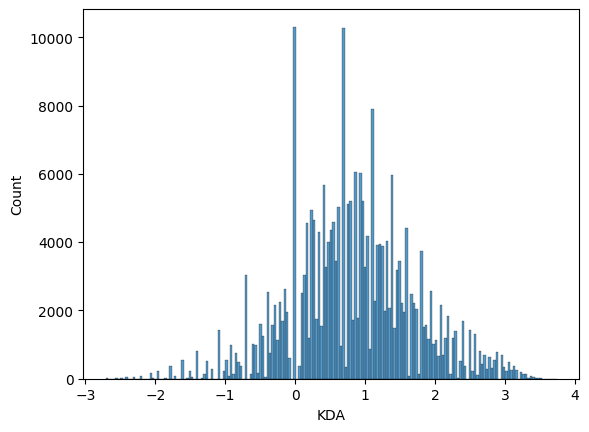

In [553]:
sns.histplot(np.log(data['KDA']))

<Axes: xlabel='KDA', ylabel='Count'>

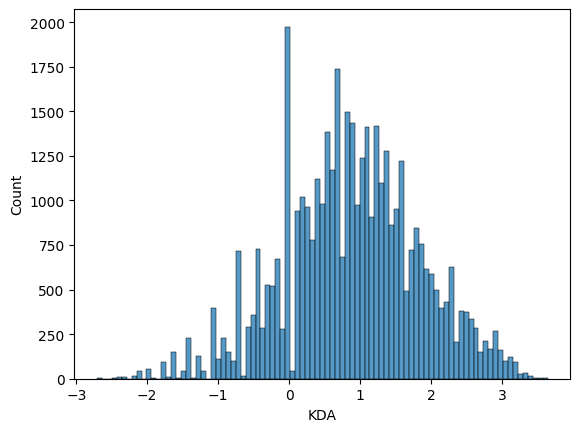

In [554]:
sns.histplot(np.log(diamond_data['KDA']))

In [555]:
# # 로그 변환
# log_kda = np.log(data['KDA'])

# # 히스토그램 계산
# counts, bin_edges = np.histogram(log_kda, bins='auto')

# # 최대 빈도 수와 해당 빈도가 발생하는 도수 범위 찾기
# max_count = counts.max()
# max_index = counts.argmax()
# max_bin_range = (bin_edges[max_index], bin_edges[max_index + 1])

# print(f"Maximum count: {max_count}")
# print(f"Bin range with maximum count: {max_bin_range}")

# # 히스토그램 그리기
# sns.histplot(log_kda, bins='auto')
# plt.title('(KDA)')
# plt.xlabel('(KDA)')
# plt.ylabel('Frequency')
# plt.show()

In [556]:
# # 범위 내 데이터 필터링
# filtered_data = data[(log_kda >= max_bin_range[0]) & (log_kda < max_bin_range[1])]

# filtered_data.shape()

In [557]:
# # 샘플링
# if len(filtered_data) > 2000:
#     sampled_data = filtered_data.sample(n=2000, random_state=2023)
# else:
#     sampled_data = filtered_data  # 데이터가 2000개 이하면 전체 데이터 사용

# # 샘플 데이터만
# data = pd.concat([data[~data.index.isin(filtered_data.index)], sampled_data])

# data.shape()

In [558]:
# # 로그 변환
# log_kda = np.log(data['KDA'])

# # 히스토그램 계산
# counts, bin_edges = np.histogram(log_kda, bins='auto')

# # 최대 빈도 수와 해당 빈도가 발생하는 도수 범위 찾기
# max_count = counts.max()
# max_index = counts.argmax()
# max_bin_range = (bin_edges[max_index], bin_edges[max_index + 1])

# print(f"Maximum count: {max_count}")
# print(f"Bin range with maximum count: {max_bin_range}")

# # 히스토그램 그리기
# sns.histplot(log_kda, bins='auto')
# plt.title('Histogram of log(KDA)')
# plt.xlabel('log(KDA)')
# plt.ylabel('Frequency')
# plt.show()

In [559]:
# data['KDA'] = np.log(data['KDA'])

### visionScorePerMinute, pings.per.min

<Axes: xlabel='visionScorePerMinute', ylabel='Count'>

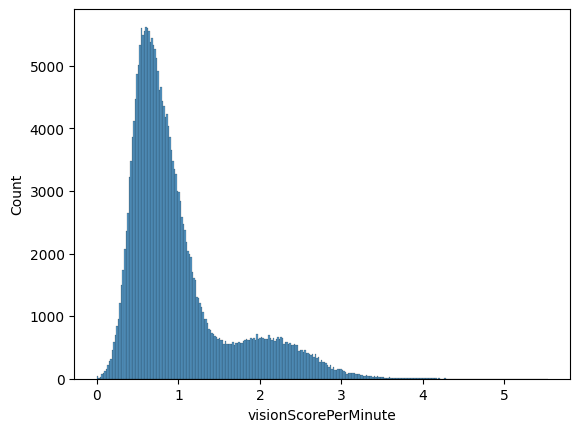

In [560]:
sns.histplot(data['visionScorePerMinute'])
# 해당 변수의 약한 양봉형은 위 티어별 그래프 차이로 보건대, 티어의 차이나 여타 변수와의 관계가 있지 않고 게이머의 특성 차이로 보인다.
# 해당 지표는 visionScorePerMinute 이렇게 통합적인 지표로 보지말고 와드 설치 개수 같은 단일 개체로 보는게 좋을 것 같다.

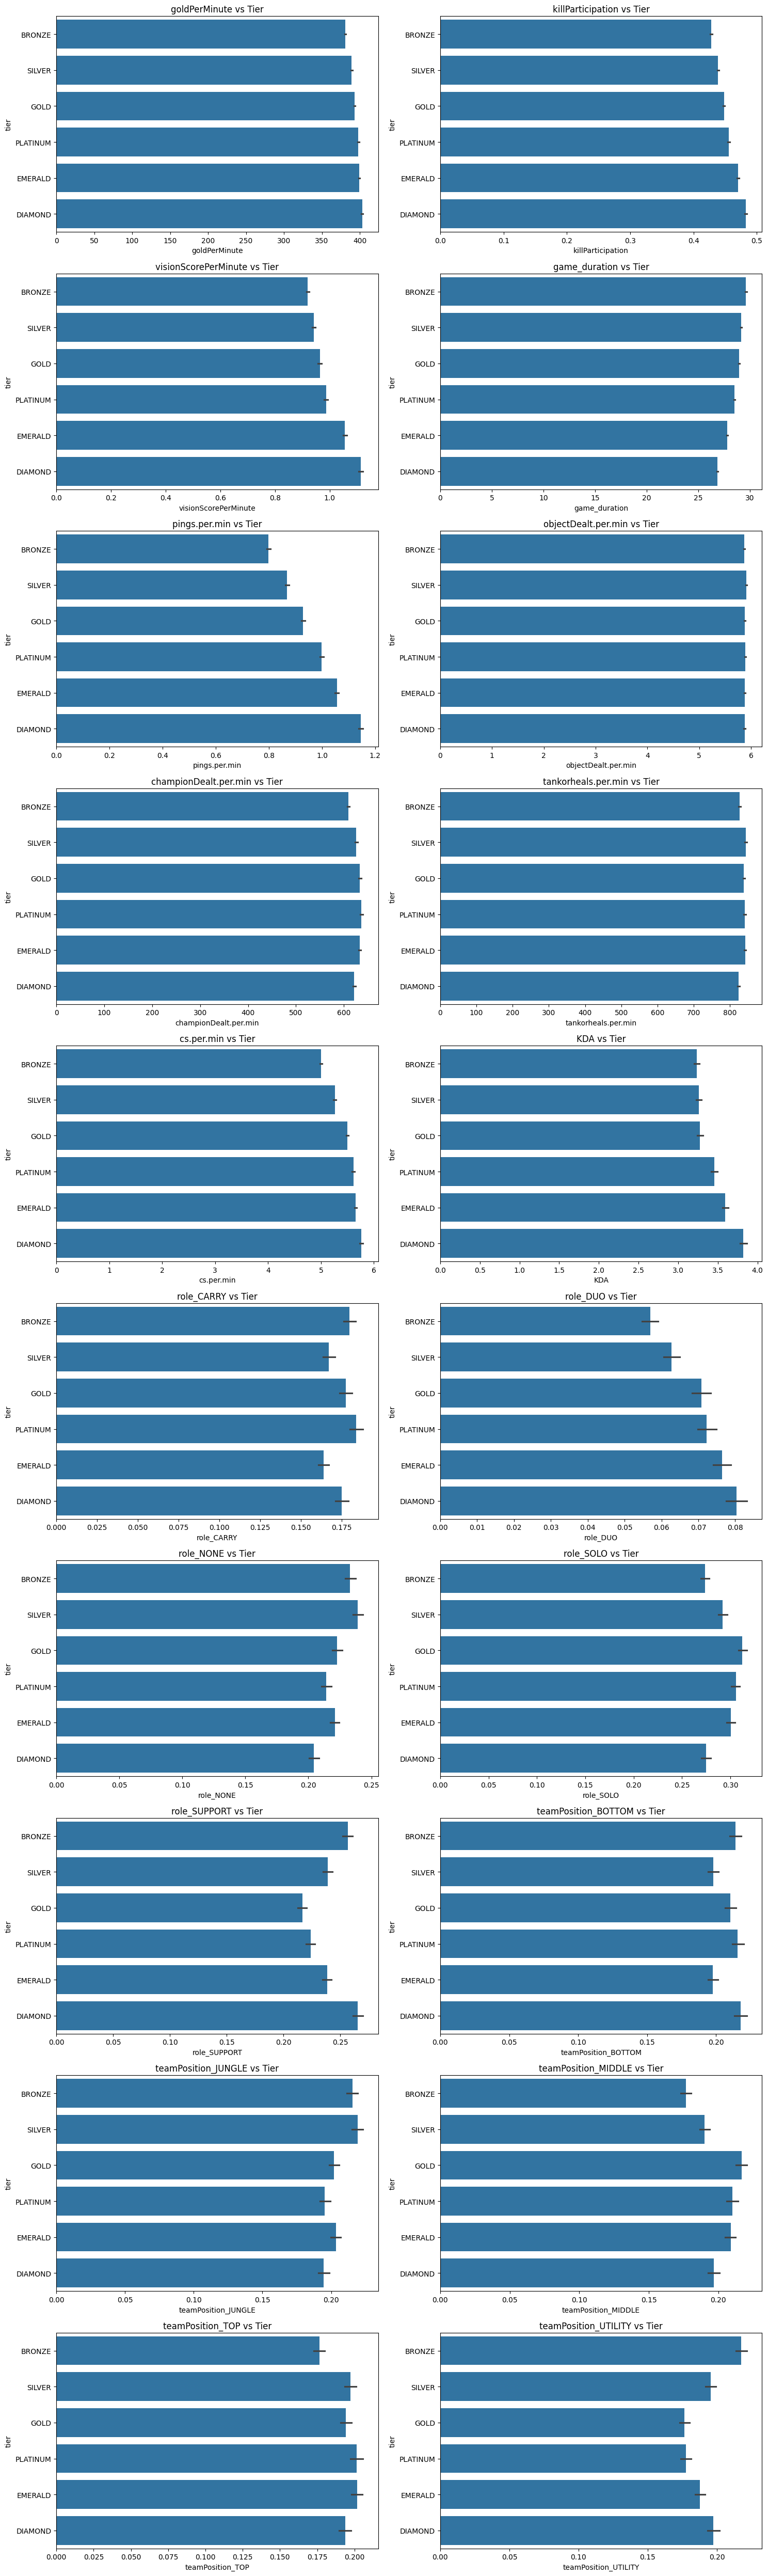

In [561]:
variables = [col for col in data.columns if col != 'tier']
fig, axes = plt.subplots(10, 2, figsize=(15, 10 * 5))
axes = axes.flatten()

for idx, i in enumerate(variables):
    if i != 'tier':
        sns.barplot(x=data[i], y=data['tier'], order=tier_order, ax=axes[idx])
        axes[idx].set_title(f'{i} vs Tier')
    else : continue

plt.tight_layout()
plt.show()

In [562]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [563]:
# boolean 전부 실수형으로
bool_columns = data.select_dtypes(include='bool').columns
data[bool_columns] = data[bool_columns].astype(float)
print(data.dtypes)

goldPerMinute            float64
killParticipation        float64
visionScorePerMinute     float64
game_duration            float64
pings.per.min            float64
objectDealt.per.min      float64
championDealt.per.min    float64
tankorheals.per.min      float64
cs.per.min               float64
KDA                      float64
tier                      object
role_CARRY               float64
role_DUO                 float64
role_NONE                float64
role_SOLO                float64
role_SUPPORT             float64
teamPosition_BOTTOM      float64
teamPosition_JUNGLE      float64
teamPosition_MIDDLE      float64
teamPosition_TOP         float64
teamPosition_UTILITY     float64
dtype: object


In [564]:
float_data = data.select_dtypes(include='float64')

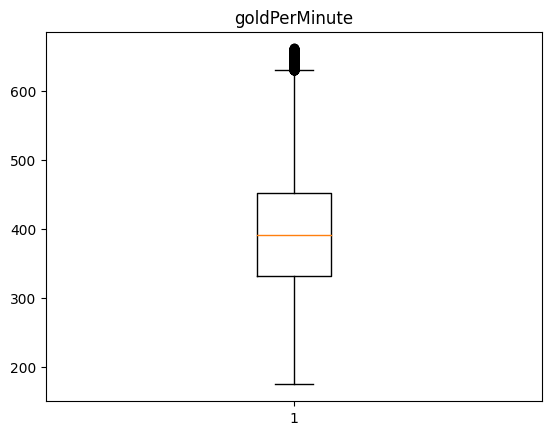

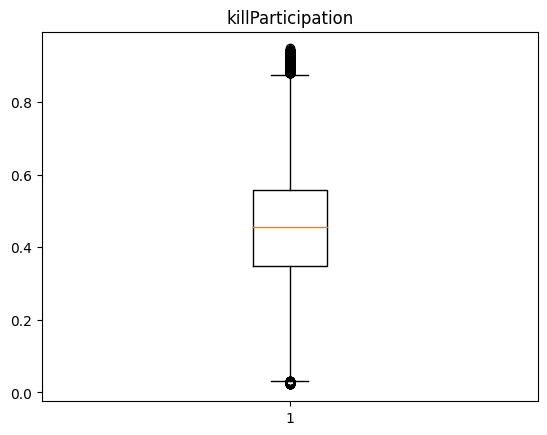

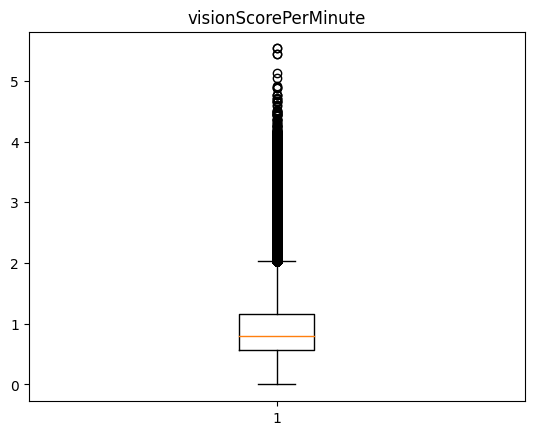

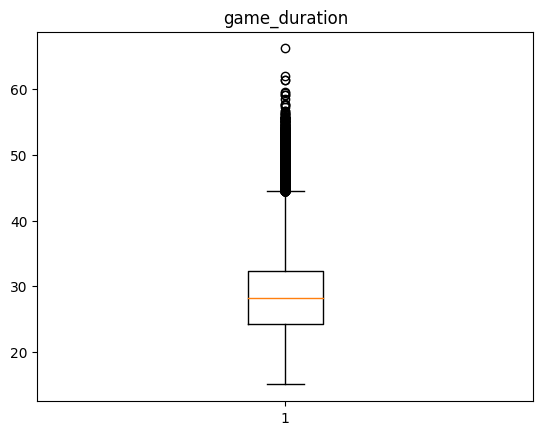

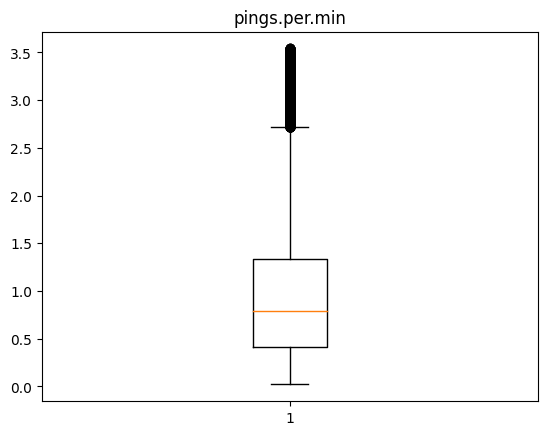

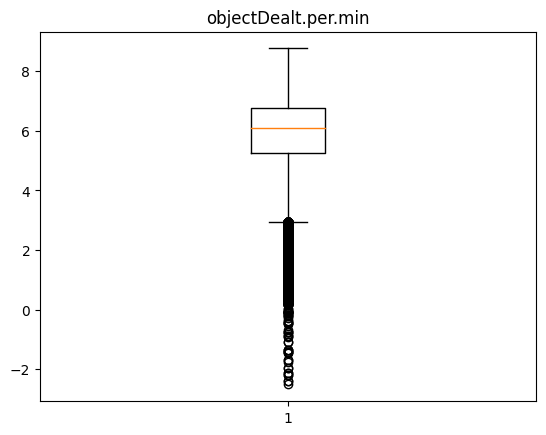

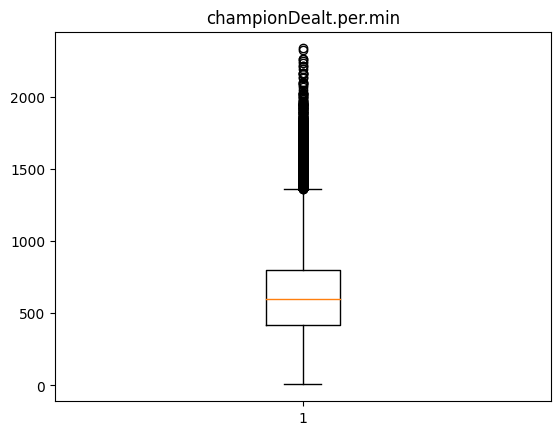

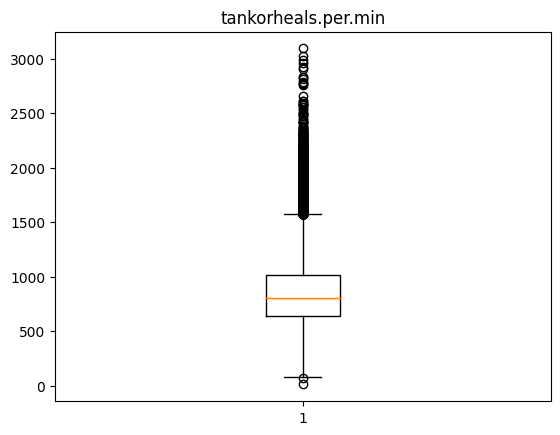

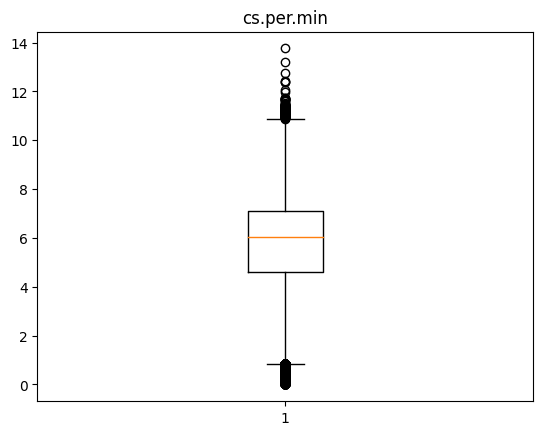

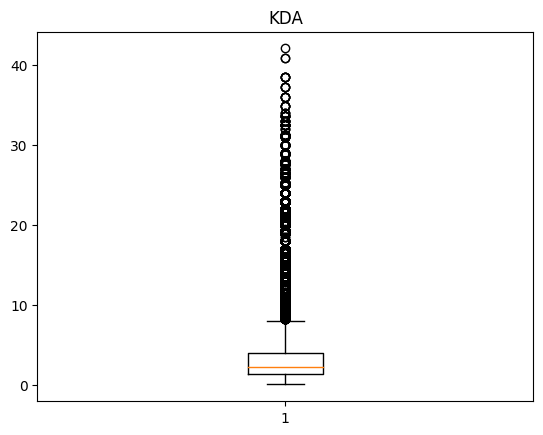

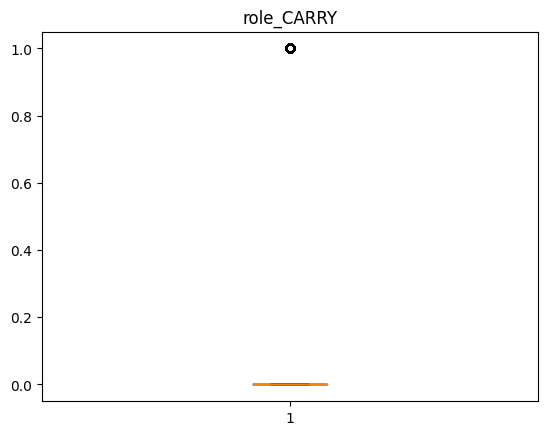

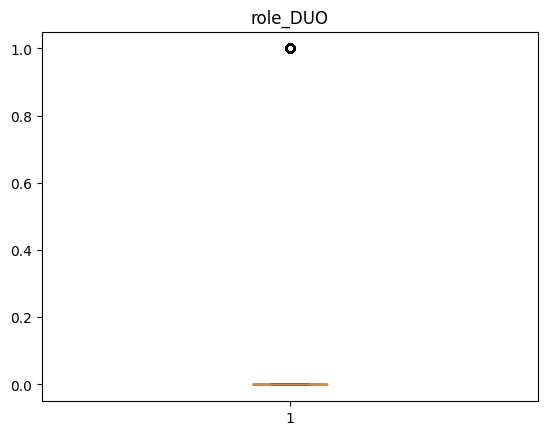

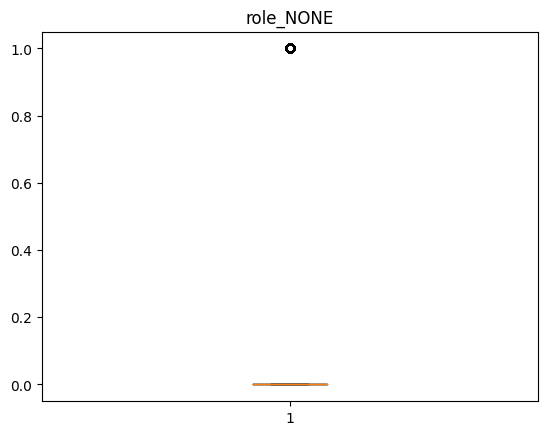

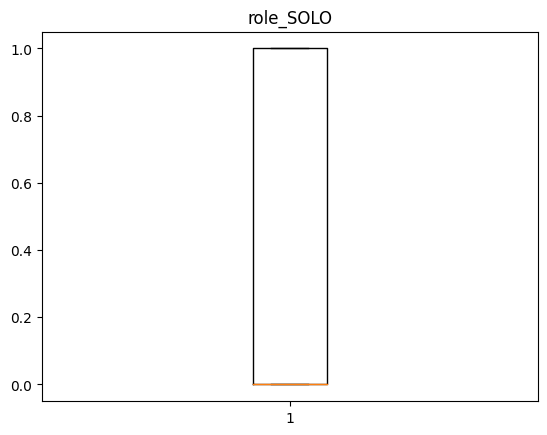

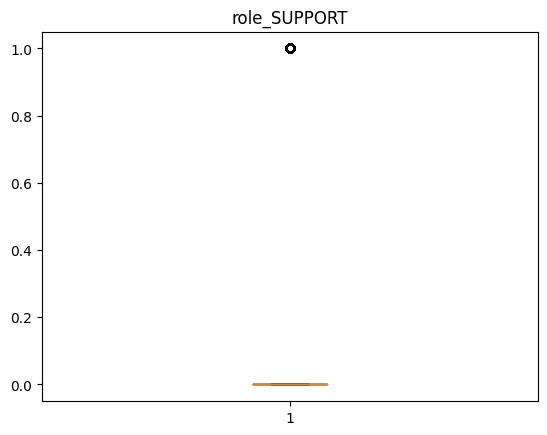

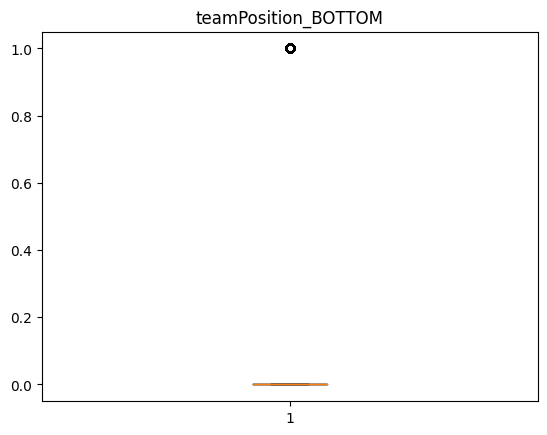

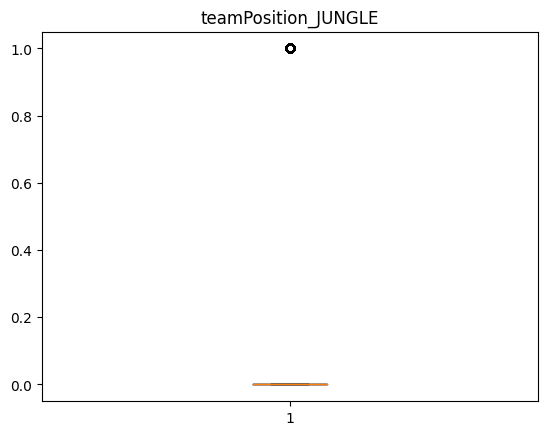

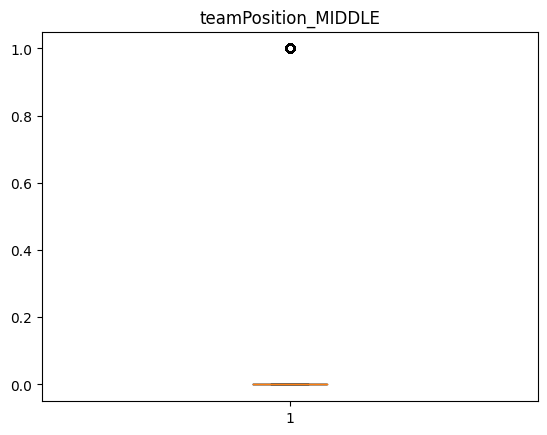

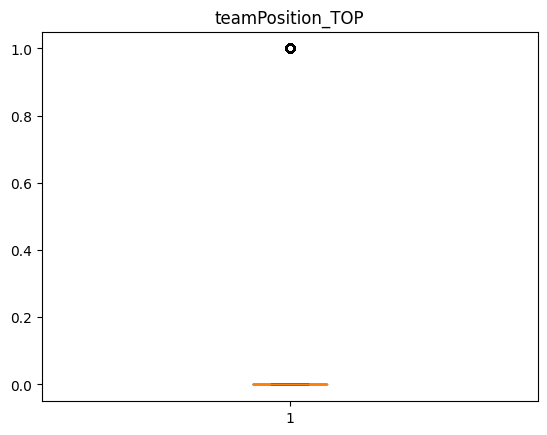

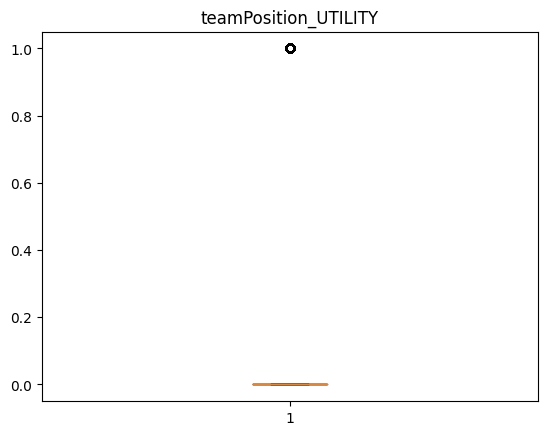

In [565]:
for col in float_data.columns:
    plt.boxplot(float_data[col])
    plt.title(col)
    plt.show()


In [566]:
len(data['tier'])

250003

In [567]:
data.columns

Index(['goldPerMinute', 'killParticipation', 'visionScorePerMinute',
       'game_duration', 'pings.per.min', 'objectDealt.per.min',
       'championDealt.per.min', 'tankorheals.per.min', 'cs.per.min', 'KDA',
       'tier', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO',
       'role_SUPPORT', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
       'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY'],
      dtype='object')

In [568]:
#visionScorePerMinute < 5, game_duration < 60 , objectDealt.per.min > -1, championDealt.per.min < 2300, 0< tankorheals.per.min < 2600, cs.per.min < 12 , KDA < 23

In [569]:
data = data[
    (data['visionScorePerMinute'] < 5) &
    (data['game_duration'] < 60) &
    (data['objectDealt.per.min'] > -1) &
    (data['championDealt.per.min'] < 2300) &
    (data['tankorheals.per.min'] > 0) &
    (data['tankorheals.per.min'] < 2600) &
    (data['cs.per.min'] < 12) &
    (data['KDA'] < 23)
]

In [570]:
len(data)

248731

<Axes: >

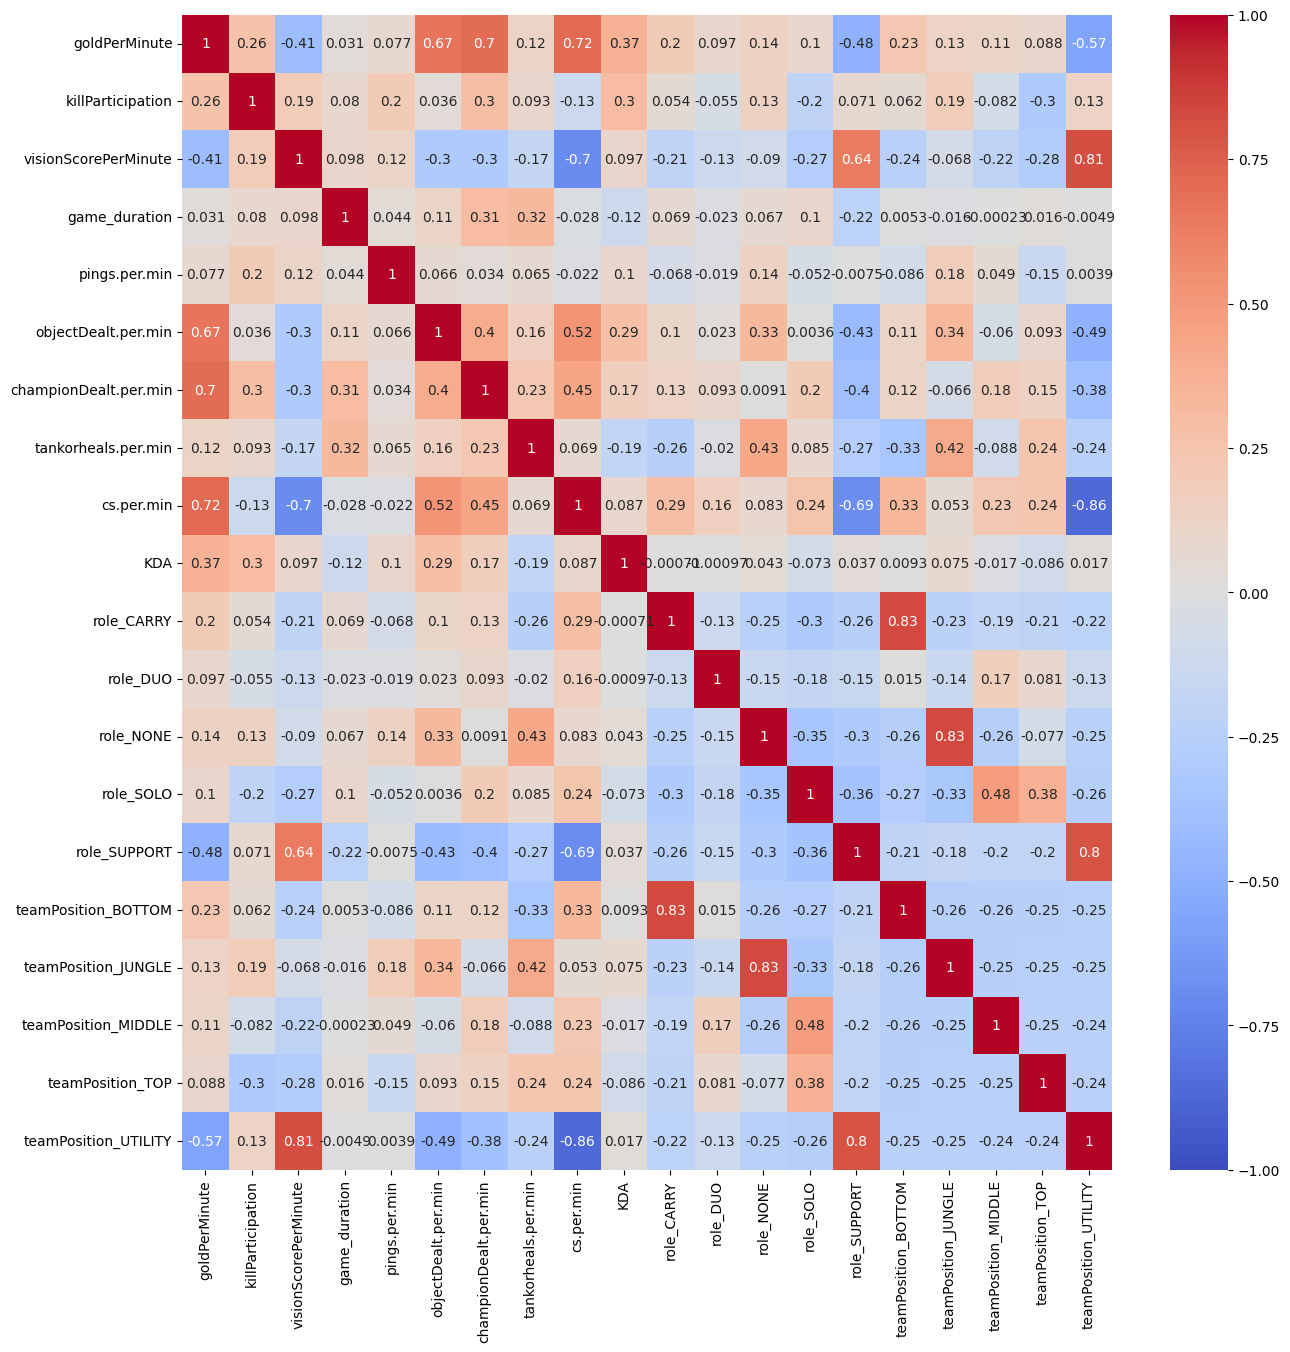

In [571]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(numeric_only=True),cmap='coolwarm',vmax=1,vmin=-1,annot=True)

In [572]:
# 다중공선성
# 'tier' 컬럼을 제외한 데이터프레임 생성
data_no_tier = data.drop(columns=['tier'])
X = data_no_tier.values
vif_data = pd.DataFrame()
vif_data["feature"] = data_no_tier.columns

In [573]:
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                  feature       VIF
0           goldPerMinute  5.958769
1       killParticipation  1.755348
2    visionScorePerMinute  3.496415
3           game_duration  1.604543
4           pings.per.min  1.104777
5     objectDealt.per.min  2.389983
6   championDealt.per.min  2.888250
7     tankorheals.per.min  2.011390
8              cs.per.min  7.661010
9                     KDA  1.490785
10             role_CARRY       inf
11               role_DUO       inf
12              role_NONE       inf
13              role_SOLO       inf
14           role_SUPPORT       inf
15    teamPosition_BOTTOM       inf
16    teamPosition_JUNGLE       inf
17    teamPosition_MIDDLE       inf
18       teamPosition_TOP       inf
19   teamPosition_UTILITY       inf


In [574]:
# 스케일링
from sklearn.preprocessing import StandardScaler

In [575]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248731 entries, 0 to 121904
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   goldPerMinute          248731 non-null  float64
 1   killParticipation      248731 non-null  float64
 2   visionScorePerMinute   248731 non-null  float64
 3   game_duration          248731 non-null  float64
 4   pings.per.min          248731 non-null  float64
 5   objectDealt.per.min    248731 non-null  float64
 6   championDealt.per.min  248731 non-null  float64
 7   tankorheals.per.min    248731 non-null  float64
 8   cs.per.min             248731 non-null  float64
 9   KDA                    248731 non-null  float64
 10  tier                   248731 non-null  object 
 11  role_CARRY             248731 non-null  float64
 12  role_DUO               248731 non-null  float64
 13  role_NONE              248731 non-null  float64
 14  role_SOLO              248731 non-null  f

In [576]:
data.columns

Index(['goldPerMinute', 'killParticipation', 'visionScorePerMinute',
       'game_duration', 'pings.per.min', 'objectDealt.per.min',
       'championDealt.per.min', 'tankorheals.per.min', 'cs.per.min', 'KDA',
       'tier', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO',
       'role_SUPPORT', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
       'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY'],
      dtype='object')

In [577]:
# 스케일링 X
target_columns = [
    'tier', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO',
    'role_SUPPORT', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
    'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY'
]
target = data[target_columns]

# 스케일링 O
features_columns = [col for col in data.columns if col not in target_columns]
features = data[features_columns]

In [650]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_columns)
data = pd.concat([scaled_features_df, target.reset_index(drop=True)], axis=1)

In [651]:
# 원하는 순서대로
tier_order = ['BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND']
data['tier'] = pd.Categorical(data['tier'], categories=tier_order, ordered=True)
data['tier'] = data['tier'].cat.codes

In [652]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# data['tier'] = label_encoder.fit_transform(data['tier'])
# data['tier']

In [623]:
# print(label_encoder.classes_)

['BRONZE' 'DIAMOND' 'EMERALD' 'GOLD' 'PLATINUM' 'SILVER']


In [653]:
data['tier']

,tier
0,0
1,0
2,0
3,0
4,0
...,...
248726,1
248727,4
248728,1
248729,5


In [654]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248731 entries, 0 to 248730
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   goldPerMinute          248731 non-null  float64
 1   killParticipation      248731 non-null  float64
 2   visionScorePerMinute   248731 non-null  float64
 3   game_duration          248731 non-null  float64
 4   pings.per.min          248731 non-null  float64
 5   objectDealt.per.min    248731 non-null  float64
 6   championDealt.per.min  248731 non-null  float64
 7   tankorheals.per.min    248731 non-null  float64
 8   cs.per.min             248731 non-null  float64
 9   KDA                    248731 non-null  float64
 10  tier                   248731 non-null  int8   
 11  role_CARRY             248731 non-null  float64
 12  role_DUO               248731 non-null  float64
 13  role_NONE              248731 non-null  float64
 14  role_SOLO              248731 non-nu

In [655]:
data

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,-0.628588,-1.123647,-0.288281,-0.939287,1.767691,-0.540756,-0.754692,-1.807008,-0.274781,1.686529,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.370786,-0.551683,1.347968,-0.395779,0.151281,-0.290390,-0.330314,-1.468398,-1.845056,-0.466616,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.118341,0.530374,2.565380,-1.147262,0.527871,-0.246570,0.379505,-1.800870,-1.848239,1.389544,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.150254,1.092780,2.421081,2.407724,0.766719,-0.751466,0.232850,-0.671730,-1.747728,-0.128382,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.773433,-0.469460,3.116396,-0.295951,0.796148,-0.323418,-0.788305,-1.015387,-1.666613,-0.194379,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248726,-0.801303,1.405227,-1.005286,-2.184364,0.288201,-1.096995,-0.981273,-1.495485,0.679650,-0.689355,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
248727,-1.100173,-0.781907,-1.298793,-2.156634,0.091384,-0.060305,-1.157559,0.636463,-0.081168,-0.949217,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
248728,-0.668228,0.780332,-0.385545,-2.220413,-0.975646,0.062975,-0.774756,1.137899,-0.025273,-0.748752,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
248729,-0.591605,-0.950149,-0.017309,-2.176045,3.264504,1.158959,-1.437865,-0.850816,0.207577,0.439190,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [630]:
from sklearn.model_selection import train_test_split

In [657]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('tier',axis=1), data['tier'], test_size=0.2,shuffle=True, random_state=2023)

In [658]:
y_train

,tier
193331,2
13679,0
27568,5
227414,1
42199,4
...,...
169889,4
182967,4
178630,4
22041,5


In [633]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(198984, 20)
(49747, 20)
(198984,)
(49747,)


In [634]:
from sklearn.ensemble import RandomForestClassifier

In [635]:
rf = RandomForestClassifier(random_state=2023)

In [636]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=2023)

In [637]:
pred1 = rf.predict(X_test)

In [639]:
accuracy_score(y_test,pred1)

0.49930649084366896

In [ ]:
# 'BRONZE' : 0
# 'SILVER' : 1
# 'GOLD' : 2
# 'PLATINUM' : 3
# 'EMERALD' : 4
# 'DIAMOND' : 5

In [640]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55      8184
           1       0.49      0.48      0.48      8512
           2       0.52      0.49      0.51      8729
           3       0.49      0.39      0.43      8081
           4       0.48      0.56      0.52      9168
           5       0.50      0.47      0.48      7073

    accuracy                           0.50     49747
   macro avg       0.50      0.50      0.50     49747
weighted avg       0.50      0.50      0.50     49747



In [500]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [498]:
# params = {
#     'max_depth' : [30,40,50],
#     'min_samples_split' : [2,3,4],
#     'n_estimators' : [100,120,140]
# }

In [499]:
# rf2 = RandomForestClassifier(random_state=2023)
# # grid_df = GridSearchCV(rf2,params,cv=5)
# grid_df = GridSearchCV(rf2,params)
# grid_df.fit(X_train,y_train)
# 시간;

In [501]:
# grid_df.best_params_

In [605]:
import xgboost as xgb
from sklearn.metrics import classification_report

In [641]:
# 2. XGBoost
xgb_model = xgb.XGBClassifier(random_state=2023)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Report:")
print(classification_report(y_test, xgb_predictions))
print(f"Accuracy: {accuracy_score(y_test, xgb_predictions):.4f}\n")

XGBoost Report:
              precision    recall  f1-score   support

           0       0.35      0.45      0.40      8184
           1       0.28      0.26      0.27      8512
           2       0.27      0.22      0.24      8729
           3       0.26      0.14      0.18      8081
           4       0.28      0.40      0.33      9168
           5       0.33      0.32      0.33      7073

    accuracy                           0.30     49747
   macro avg       0.30      0.30      0.29     49747
weighted avg       0.29      0.30      0.29     49747

Accuracy: 0.2993



In [642]:
!pip install lightgbm

In [643]:
# 3. LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=2023)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)

print("LightGBM Report:")
print(classification_report(y_test, lgb_predictions))
print(f"Accuracy: {accuracy_score(y_test, lgb_predictions):.4f}\n")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 198984, number of used features: 20
[LightGBM] [Info] Start training from score -1.822843
[LightGBM] [Info] Start training from score -1.757409
[LightGBM] [Info] Start training from score -1.744872
[LightGBM] [Info] Start training from score -1.804780
[LightGBM] [Info] Start training from score -1.699233
[LightGBM] [Info] Start training from score -1.938350
LightGBM Report:
              precision    recall  f1-score   support

           0       0.33      0.46      0.39      8184
           1       0.25      0.23      0.24      8512
           2       0.24      0.17      0.20      8729
           3       0.26      0.10      0.14      8081
           4       0.26      0.41 

In [ ]:
# 변수 재선택 및 파생변수 생성 절실.

In [662]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('tier',axis=1), data['tier'], test_size=0.2,shuffle=True, random_state=2023)

In [664]:
# 텐서변환을 위한 배열
numpy_array1 = X_train.to_numpy()
numpy_array2 = X_test.to_numpy()
numpy_array3 = y_train.to_numpy()
numpy_array4 = y_test.to_numpy()

In [665]:
X_train = torch.tensor(numpy_array1, dtype=torch.float32)
X_test = torch.tensor(numpy_array2, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [666]:
# 모델 정의
class MLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [667]:
# 모델, 손실 함수 및 옵티마이저 초기화
input_dim = X_train.shape[1]
output_dim = len(y_train.unique())

model = MLPModel(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [669]:
# 하이퍼파라미터
epochs = 5000

# 학습 루프
for epoch in range(epochs + 1):
    model.train()
    optimizer.zero_grad()

    # 모델 예측
    y_pred = model(X_train)

    # 손실 계산
    loss = criterion(y_pred, y_train)

    # 역전파 및 옵티마이저 단계
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        # 정확도 계산
        with torch.no_grad():
            model.eval()
            y_pred_test = model(X_test)
            _, predicted = torch.max(y_pred_test, 1)
            correct = (predicted == y_test).sum().item()
            accuracy = (correct / len(y_test)) * 100
            print(f'Epoch {epoch:4d}/{epochs} Loss: {loss.item():.6f} Accuracy: {accuracy:.2f}%')

# # 배치 설정 없이 했을 때. 비슷함.

Epoch    0/5000 Loss: 1.785402 Accuracy: 19.18%
Epoch   10/5000 Loss: 1.769294 Accuracy: 22.57%
Epoch   20/5000 Loss: 1.747776 Accuracy: 24.06%
Epoch   30/5000 Loss: 1.731610 Accuracy: 25.15%
Epoch   40/5000 Loss: 1.721678 Accuracy: 25.41%
Epoch   50/5000 Loss: 1.716419 Accuracy: 25.75%
Epoch   60/5000 Loss: 1.711689 Accuracy: 25.81%
Epoch   70/5000 Loss: 1.708441 Accuracy: 25.92%
Epoch   80/5000 Loss: 1.706718 Accuracy: 25.97%
Epoch   90/5000 Loss: 1.704550 Accuracy: 25.98%
Epoch  100/5000 Loss: 1.702511 Accuracy: 26.09%
Epoch  110/5000 Loss: 1.701524 Accuracy: 26.09%
Epoch  120/5000 Loss: 1.700088 Accuracy: 26.15%
Epoch  130/5000 Loss: 1.698668 Accuracy: 26.19%
Epoch  140/5000 Loss: 1.697761 Accuracy: 26.27%
Epoch  150/5000 Loss: 1.696991 Accuracy: 26.20%
Epoch  160/5000 Loss: 1.696087 Accuracy: 26.21%
Epoch  170/5000 Loss: 1.695553 Accuracy: 26.18%
Epoch  180/5000 Loss: 1.694961 Accuracy: 26.19%
Epoch  190/5000 Loss: 1.694120 Accuracy: 26.22%
Epoch  200/5000 Loss: 1.693093 Accuracy:

KeyboardInterrupt: 

In [ ]:
# 새 데이터를 받아올 시간 부족
# 라이엇 API 호출 제한 규정 : 한 번에 20회, 2분에 100회 제한

### **파이참(GPU를 사용한 좀 더 깊은 MLP)**

In [ ]:
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     data.drop('tier', axis=1),
#     data['tier'],
#     test_size=0.2,
#     shuffle=True,
#     random_state=2023
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_full,
#     y_train_full,
#     test_size=0.2,
#     shuffle=True,
#     random_state=2023
# )

# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)
# print(y_train.shape)
# print(y_test.shape)
# print(y_val.shape)

In [ ]:
# # 텐서형으로 변환을 위한 배열 정리
# numpy_array1 = X_train.to_numpy()
# numpy_array2 = X_test.to_numpy()
# numpy_array3 = y_train.to_numpy()
# numpy_array4 = y_test.to_numpy()
# numpy_array5 = X_val.to_numpy()
# numpy_array6 = y_val.to_numpy()

# # 탠서변환
# X_train = torch.tensor(numpy_array1, dtype=torch.float32)
# X_test = torch.tensor(numpy_array2, dtype=torch.float32)
# y_train = torch.tensor(numpy_array3, dtype=torch.long)
# y_test = torch.tensor(numpy_array4, dtype=torch.long)
# X_val = torch.tensor(numpy_array5, dtype=torch.float32)
# y_val = torch.tensor(numpy_array6, dtype=torch.long)

# # 데이터셋 생성
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
# test_dataset = TensorDataset(X_test, y_test)

# def move_to_device(batch):
#     X_batch, y_batch = zip(*batch)
#     X_batch = torch.stack([x.to(device) for x in X_batch])
#     y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)
#     return X_batch, y_batch

# # 데이터 로더
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=move_to_device)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True, collate_fn=move_to_device)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True, collate_fn=move_to_device)

# # 딥러닝 모델
# class ClassificationModel(nn.Module):
#     def __init__(self):
#         super(ClassificationModel, self).__init__()
#         self.fc1 = nn.Linear(20, 4096)
#         self.fc2 = nn.Linear(4096, 2048)
#         self.fc3 = nn.Linear(2048, 1024)
#         self.fc4 = nn.Linear(1024, 512)
#         self.fc5 = nn.Linear(512, 256)
#         self.fc6 = nn.Linear(256, 128)
#         self.fc7 = nn.Linear(128, 64)
#         self.fc8 = nn.Linear(64, 32)
#         self.fc9 = nn.Linear(32, 16)
#         self.fc10 = nn.Linear(16, 8)
#         self.fc11 = nn.Linear(8, 6)  # 최종 6개 클래스

#         # ReLU 활성화 함수
#         self.relu = nn.ReLU()

#         # 드롭아웃
#         self.dropout = nn.Dropout(0.3)

#         # 배치 정규화
#         self.batch_norm1 = nn.BatchNorm1d(4096)
#         self.batch_norm2 = nn.BatchNorm1d(2048)
#         self.batch_norm3 = nn.BatchNorm1d(1024)
#         self.batch_norm4 = nn.BatchNorm1d(512)
#         self.batch_norm5 = nn.BatchNorm1d(256)
#         self.batch_norm6 = nn.BatchNorm1d(128)
#         self.batch_norm7 = nn.BatchNorm1d(64)
#         self.batch_norm8 = nn.BatchNorm1d(32)
#         self.batch_norm9 = nn.BatchNorm1d(16)
#         self.batch_norm10 = nn.BatchNorm1d(8)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm3(self.fc3(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm4(self.fc4(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm5(self.fc5(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm6(self.fc6(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm7(self.fc7(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm8(self.fc8(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm9(self.fc9(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm10(self.fc10(x)))
#         x = self.dropout(x)
#         x = self.fc11(x)
#         return x



# # GPU로
# model = ClassificationModel().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# epochs = 200

# # 학습
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     # 배치 데이터에 대해 학습 수행
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
#         loss.backward()
#         optimizer.step()

#     scheduler.step()

#     # 매 에폭마다 손실 및 정확도 출력
#     if epoch % 1 == 0:
#         with torch.no_grad():
#             model.eval()

#             val_correct = 0
#             val_total = 0
#             for X_batch, y_batch in val_loader:
#                 X_batch = X_batch.to(device)
#                 y_batch = y_batch.to(device)

#                 y_pred = model(X_batch)
#                 _, predicted = torch.max(y_pred, 1)
#                 val_total += y_batch.size(0)
#                 val_correct += (predicted == y_batch).sum().item()

#             val_accuracy = (val_correct / val_total) * 100

#             test_correct = 0
#             test_total = 0
#             for X_batch, y_batch in test_loader:
#                 X_batch = X_batch.to(device)
#                 y_batch = y_batch.to(device)

#                 y_pred = model(X_batch)
#                 _, predicted = torch.max(y_pred, 1)
#                 test_total += y_batch.size(0)
#                 test_correct += (predicted == y_batch).sum().item()

#             test_accuracy = (test_correct / test_total) * 100

#             print(f'Epoch {epoch + 1:4d}/{epochs} Loss: {loss.item():.6f} '
#                   f'Val Accuracy: {val_accuracy:.2f}% Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
# Using device: cuda
# (159169, 20)
# (49741, 20)
# (39793, 20)
# (159169,)
# (49741,)
# (39793,)
# Epoch    1/200 Loss: 1.811952 Val Accuracy: 16.38% Test Accuracy: 16.37%
# Epoch    2/200 Loss: 1.795802 Val Accuracy: 16.12% Test Accuracy: 16.21%
# Epoch    3/200 Loss: 1.789276 Val Accuracy: 18.45% Test Accuracy: 18.33%
# Epoch    4/200 Loss: 1.780264 Val Accuracy: 18.72% Test Accuracy: 18.81%
# Epoch    5/200 Loss: 1.765045 Val Accuracy: 19.16% Test Accuracy: 19.44%
# Epoch    6/200 Loss: 1.770695 Val Accuracy: 20.40% Test Accuracy: 20.50%
# Epoch    7/200 Loss: 1.770125 Val Accuracy: 20.23% Test Accuracy: 20.31%
# Epoch    8/200 Loss: 1.770433 Val Accuracy: 20.71% Test Accuracy: 20.80%
# Epoch    9/200 Loss: 1.738616 Val Accuracy: 21.52% Test Accuracy: 21.45%
# Epoch   10/200 Loss: 1.721950 Val Accuracy: 21.52% Test Accuracy: 21.49%
# Epoch   11/200 Loss: 1.776182 Val Accuracy: 21.89% Test Accuracy: 21.79%
# Epoch   12/200 Loss: 1.887852 Val Accuracy: 22.62% Test Accuracy: 22.35%
# Epoch   13/200 Loss: 1.747969 Val Accuracy: 22.63% Test Accuracy: 22.52%
# Epoch   14/200 Loss: 1.806393 Val Accuracy: 22.83% Test Accuracy: 22.83%
# Epoch   15/200 Loss: 1.828300 Val Accuracy: 23.34% Test Accuracy: 23.03%
# Epoch   16/200 Loss: 1.807903 Val Accuracy: 23.42% Test Accuracy: 23.44%
# Epoch   17/200 Loss: 1.747516 Val Accuracy: 23.79% Test Accuracy: 23.56%
# Epoch   18/200 Loss: 1.751521 Val Accuracy: 23.41% Test Accuracy: 23.43%
# Epoch   19/200 Loss: 1.791813 Val Accuracy: 24.00% Test Accuracy: 23.88%
# Epoch   20/200 Loss: 1.763119 Val Accuracy: 23.81% Test Accuracy: 23.62%
# Epoch   21/200 Loss: 1.739420 Val Accuracy: 24.46% Test Accuracy: 24.38%
# Epoch   22/200 Loss: 1.819167 Val Accuracy: 24.23% Test Accuracy: 24.11%
# Epoch   23/200 Loss: 1.708763 Val Accuracy: 24.52% Test Accuracy: 24.05%
# Epoch   24/200 Loss: 1.846381 Val Accuracy: 24.78% Test Accuracy: 24.53%
# Epoch   25/200 Loss: 1.691497 Val Accuracy: 24.54% Test Accuracy: 24.37%
# Epoch   26/200 Loss: 1.808558 Val Accuracy: 24.64% Test Accuracy: 24.28%
# Epoch   27/200 Loss: 1.730428 Val Accuracy: 24.69% Test Accuracy: 24.49%
# Epoch   28/200 Loss: 1.816351 Val Accuracy: 24.90% Test Accuracy: 24.66%
# Epoch   29/200 Loss: 1.694364 Val Accuracy: 24.93% Test Accuracy: 24.61%
# Epoch   30/200 Loss: 1.619371 Val Accuracy: 24.77% Test Accuracy: 24.34%
# Epoch   31/200 Loss: 1.709455 Val Accuracy: 24.74% Test Accuracy: 24.68%
# Epoch   32/200 Loss: 1.712560 Val Accuracy: 25.01% Test Accuracy: 24.82%
# Epoch   33/200 Loss: 1.734505 Val Accuracy: 24.96% Test Accuracy: 24.39%
# Epoch   34/200 Loss: 1.729471 Val Accuracy: 25.26% Test Accuracy: 24.94%
# Epoch   35/200 Loss: 1.711981 Val Accuracy: 25.19% Test Accuracy: 24.62%
# Epoch   36/200 Loss: 1.689825 Val Accuracy: 24.95% Test Accuracy: 24.95%
# Epoch   37/200 Loss: 1.618420 Val Accuracy: 25.38% Test Accuracy: 24.92%
# Epoch   38/200 Loss: 1.784734 Val Accuracy: 24.94% Test Accuracy: 24.92%
# Epoch   39/200 Loss: 1.827997 Val Accuracy: 25.31% Test Accuracy: 25.16%
# Epoch   40/200 Loss: 1.650418 Val Accuracy: 25.32% Test Accuracy: 25.30%
# Epoch   41/200 Loss: 1.683987 Val Accuracy: 25.31% Test Accuracy: 25.09%
# Epoch   42/200 Loss: 1.711032 Val Accuracy: 25.22% Test Accuracy: 25.15%

# 비슷함. 변수 재선택, 파생 변수 필요